In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import pylab as pl

from sklearn.cross_validation import cross_val_score 
from sklearn.cross_validation import KFold
import sklearn.preprocessing as pp
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso
from sklearn.decomposition import RandomizedPCA
from sklearn.linear_model import Ridge
from sklearn import metrics
from sklearn import cross_validation
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve
import sklearn.decomposition
import sklearn.ensemble as sk
from sklearn import linear_model
from sklearn.svm import LinearSVR
from sklearn.grid_search import GridSearchCV

import random
import sys
from scipy import stats
% matplotlib inline
%load_ext autoreload
%autoreload 2
from regression_functions import *
from reg_plots import *


#Import Data

In [2]:
pod_number = 'cham_2'

In [5]:
df_all = pd.io.parsers.read_csv(filepath_or_buffer = 'data/7_25_closed_only.csv', parse_dates = [0], index_col = 0)
df_all = df_all.rename(columns={'o3_ppb': 'O3_ppb'})

##Declare whether to process raw or filtered data.

In [6]:
which_data = 0    #1 = filtered, 0 = raw
ref_column, leave_out_pod, pod_ozone = declare_filt_or_raw_dataset(which_data)

####Call the scaling function and create a dataframe with scaled data.

In [7]:
df_scaled, features, minmax_scale_fit, standard_scale_fit = scale_features_and_create_day_column(df_all, ref_column)
len(df_scaled)

805

###Declare whether you'd like to use holdout dates from a previous run.

In [8]:
prev_holdout = "true"
chunks = ['8-10 PM']

####Add a 'day' column to the dataframe, and separate the data into training and holdout.

In [9]:
if prev_holdout == "true":
    df_tr, df_hold, chunks_tr, days_tr = sep_tr_and_holdout_pre_defined(df_scaled, ref_column, chunks)
else:
    df_tr, df_hold, chunks_tr, days_tr = sep_tr_and_holdout(df_scaled, ref_column)

df_hold ['8-10 PM']
df_hold ['8-10 PM']


In [10]:
df_hold['chunk'].unique()

array(['8-10 PM'], dtype=object)

###Declare a cutoff value for 'high' ozone.

In [11]:
cutoff_value = 40

####Plot the pod ozone, ref ozone, temp and RH.

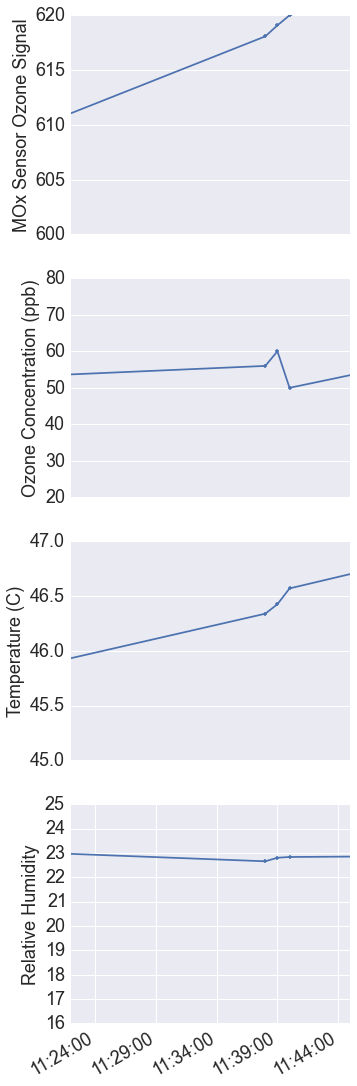

In [12]:
plot_03_temp_rh_no_scale(df_all, pod_number, ref_column, 'Training Data', cutoff_value, 5)

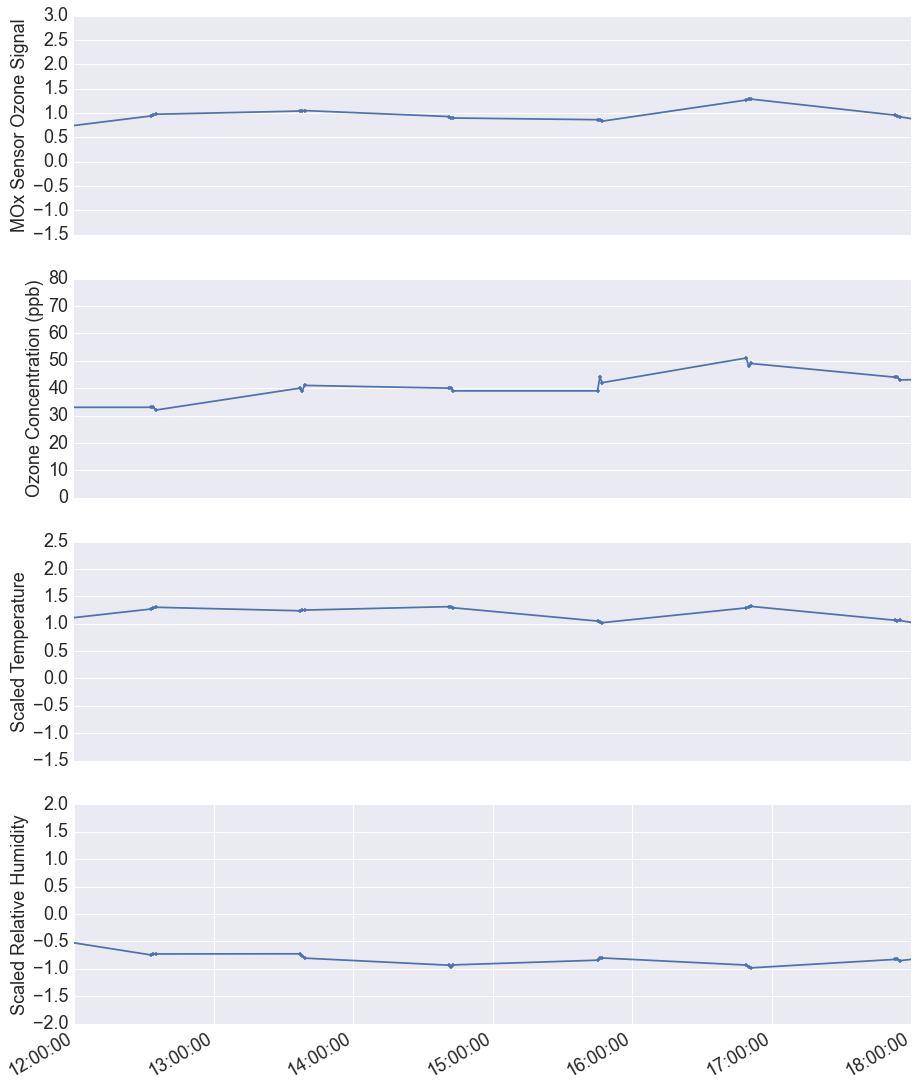

In [13]:
plot_03_temp_rh(df_tr, pod_number, ref_column, 'Training Data', cutoff_value, 4)

####Plot the training ozone

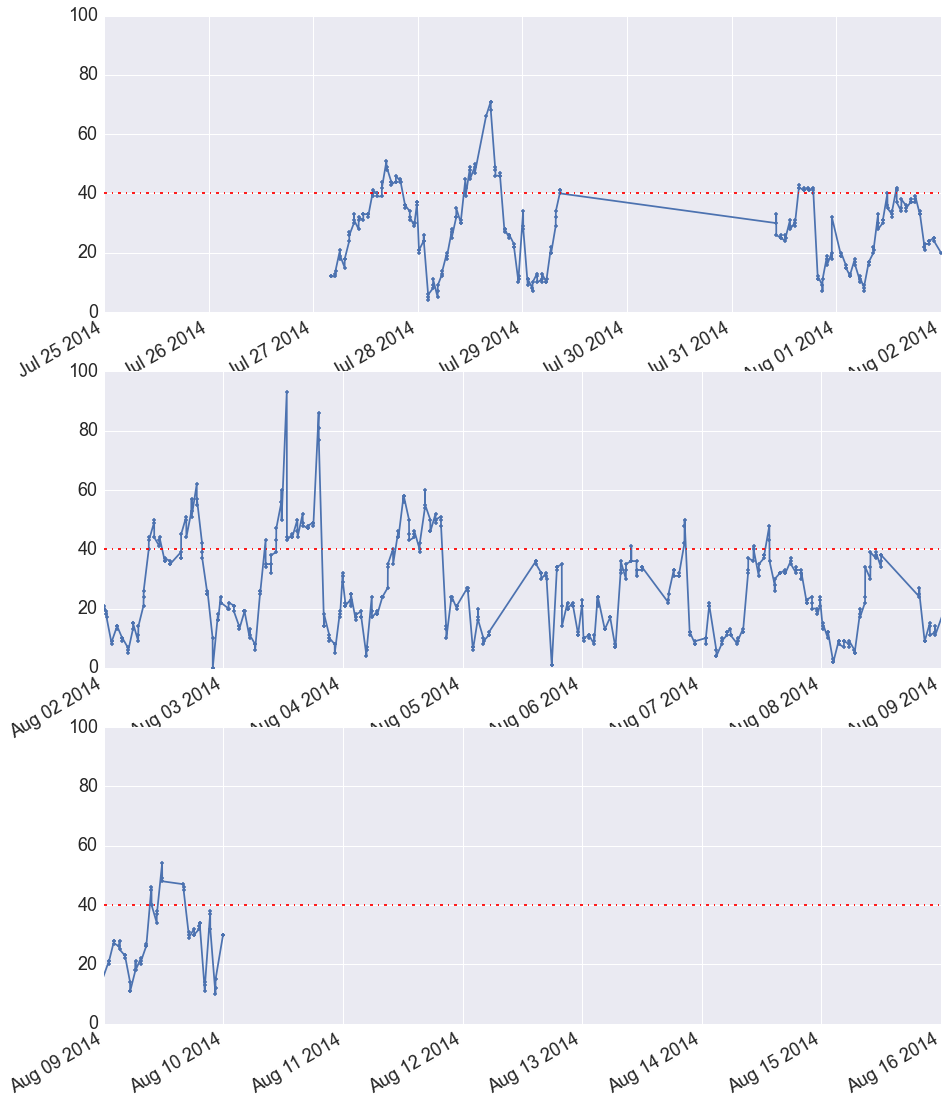

In [14]:
plot_tr_and_holdout(df_tr, pod_number, ref_column, 'Training Data', cutoff_value)

###Plot holdout ozone to make sure that the holdout set has some high-value ozone measurements.

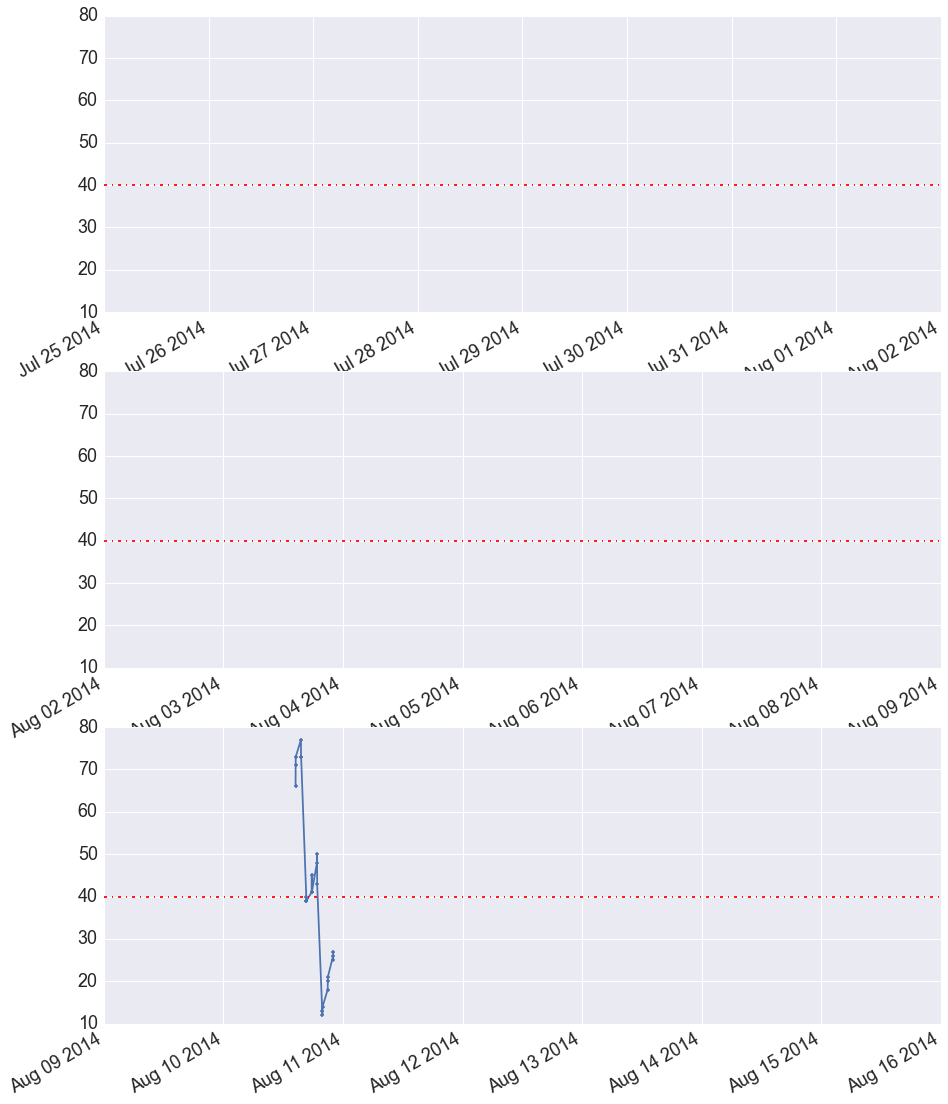

In [15]:
plot_tr_and_holdout(df_hold, pod_number, ref_column, 'Holdout Data', cutoff_value)

###Declare a multiplication factor for the MSE part of the custom score function.

In [16]:
cust_mse_fact = 1

#Linear Regression with Base Features

In [17]:
base_features = [pod_ozone,'Temp','Rh', 'no2']

/Users/berkeleyalmand/anaconda/lib/python2.7/site-packages/seaborn/linearmodels.py:1283: UserWarning: The `corrplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `corrplot` function has been deprecated in favor "
/Users/berkeleyalmand/anaconda/lib/python2.7/site-packages/seaborn/linearmodels.py:1349: UserWarning: The `symmatplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `symmatplot` function has been deprecated in favor "


/Users/berkeleyalmand/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


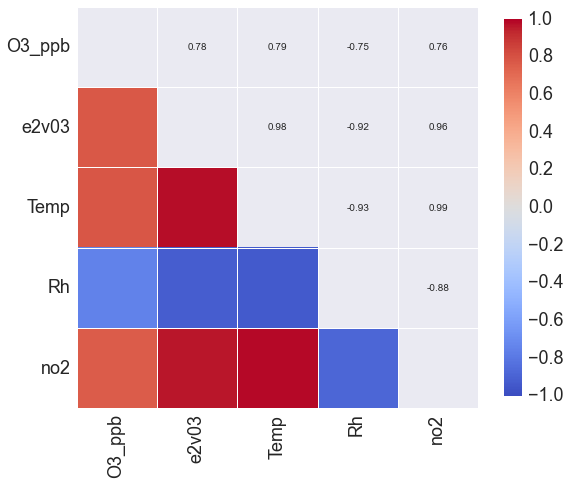

In [18]:
f, ax = plt.subplots(figsize=(9, 9))
sns.corrplot(df_tr[[ref_column] + base_features], annot=True, sig_stars=False,
             diag_names=False, ax=ax)

In [19]:
#Define the model.
lin_regr = linear_model.LinearRegression()
#find the MSE
MSE_CV, MSE_T, MSE_H, high_MSE_cv, X_pred_cv_base, y_cv, df_cv_lin_base, df_H_lin_base = cross_validation_by_day(lin_regr, base_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 8.8
Cross-Validation RMSE: 9.0 , High-Value CV RMSE: 21.0 , CV High Diff. in Mean (>40): -17.6
Holdout RMSE: 19.0 , High-Value Holdout RMSE: 33.0 , Holdout High Diff. in Mean.: -32.4


/Users/berkeleyalmand/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


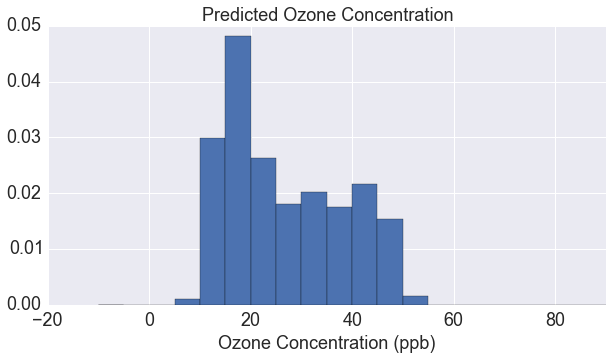

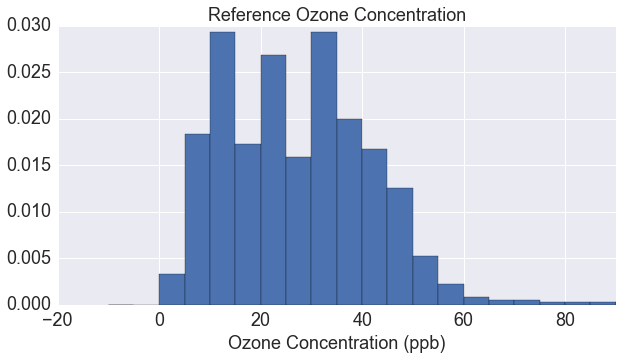

In [20]:
plot_hist(X_pred_cv_base, y_cv, 'Predicted Ozone Concentration')
plot_hist(y_cv, X_pred_cv_base, 'Reference Ozone Concentration')

####Plot the learning curve for a linear regression with the base features.

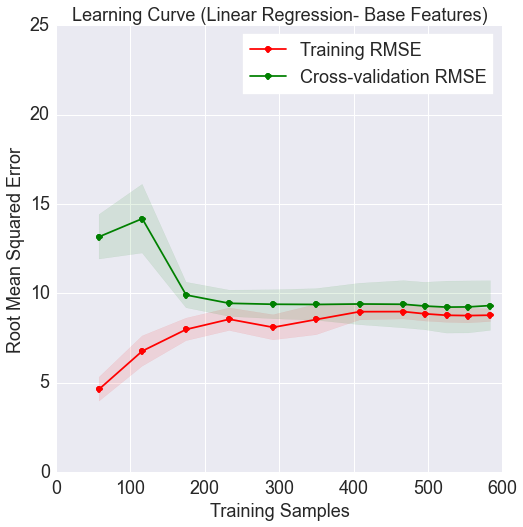

In [21]:
plt = plot_learning_curve(lin_regr, "Learning Curve (Linear Regression- Base Features)", df_tr[base_features].values, df_tr[ref_column].values, (0,25), days_tr, np.array([ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1.0]))

The MSE is high for the cross-validation set in this plot, and the training and cross-validation scores come together in this plot tells us that we have resonably high bias. Create more features and add polynomial effects to reduce bias. 

###Plot the residuals and comparison curves.

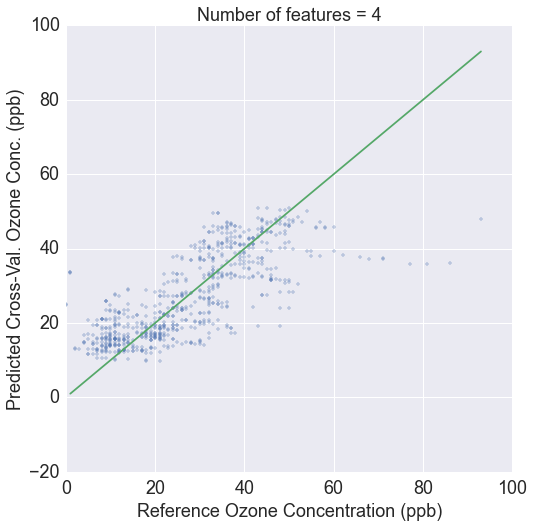

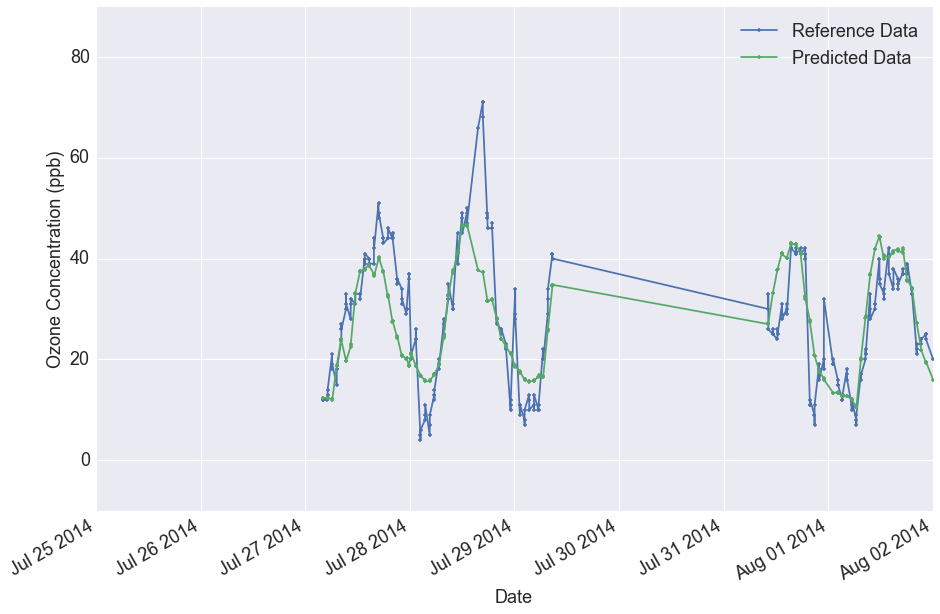

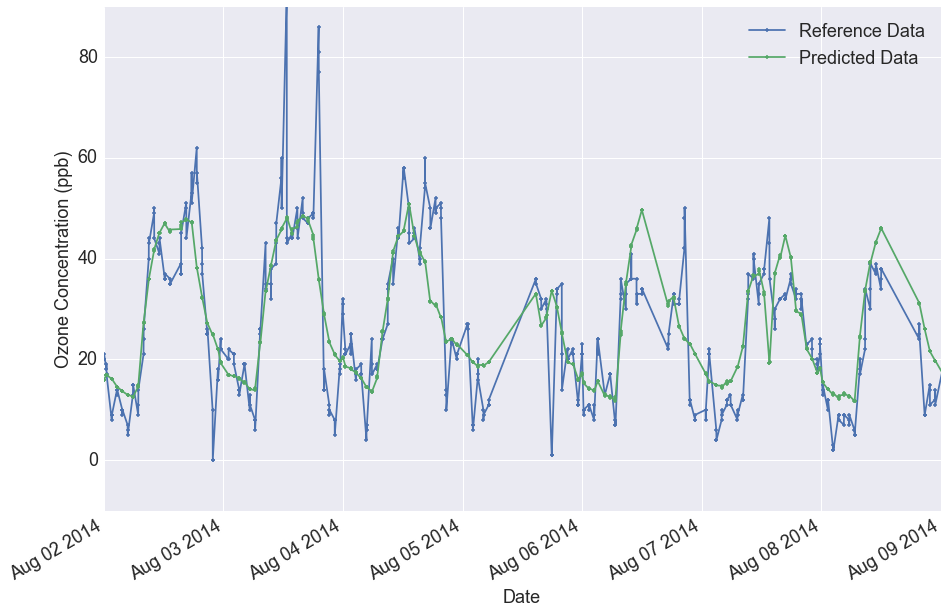

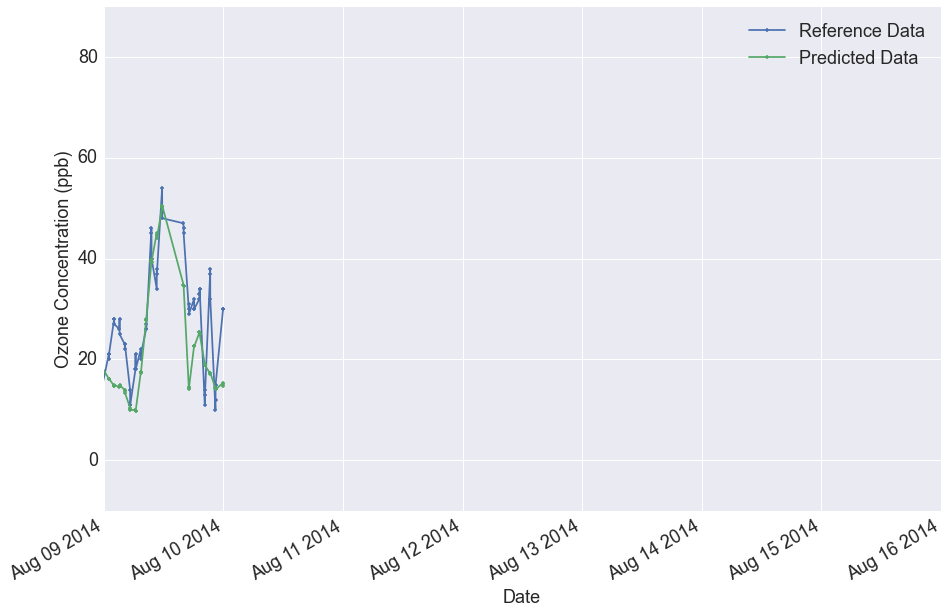

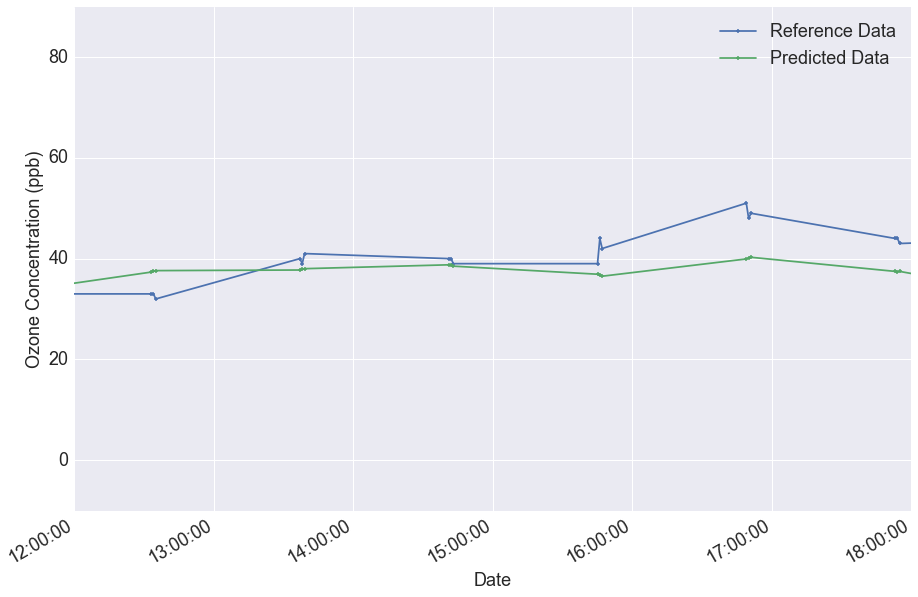

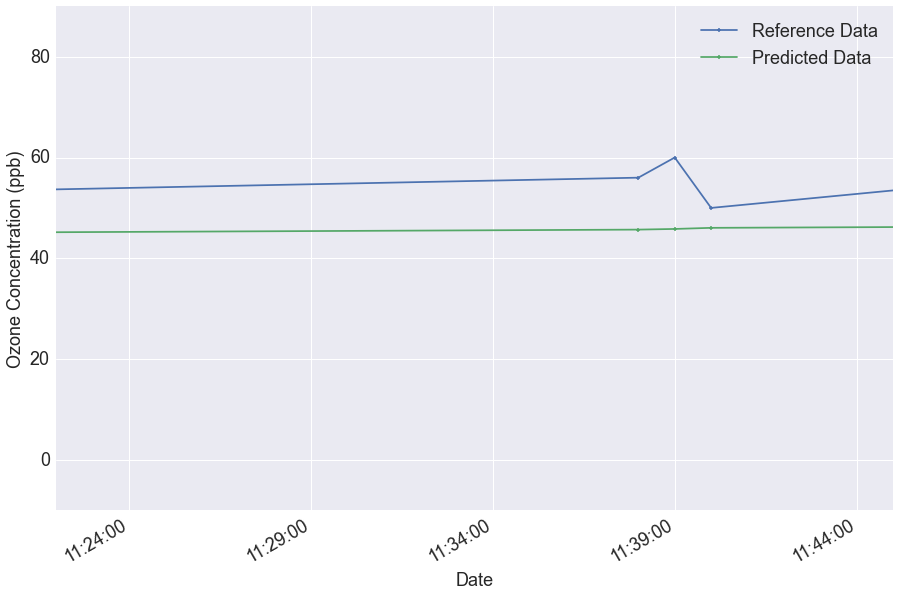

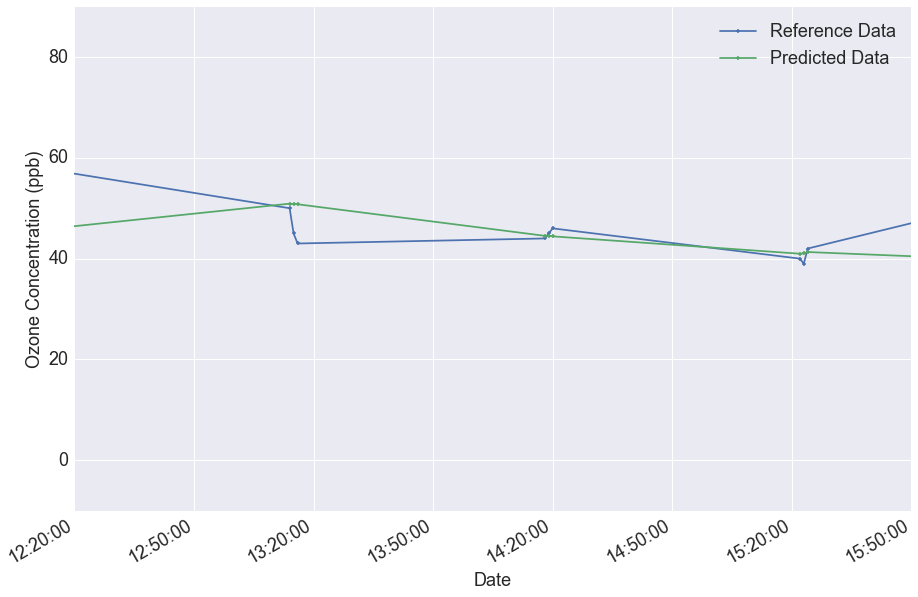

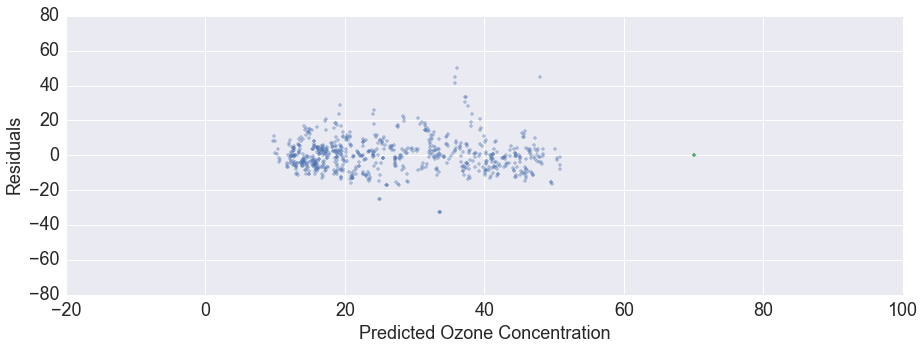

In [22]:
num_good_feat = len(base_features)
fitted_vs_ref_plot(df_cv_lin_base, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_base, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_base, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_base, pod_number, 3, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_base, pod_number, 4, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_base, pod_number, 5, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_base, pod_number, 6, ref_column)
resid = plot_resid_vs_conc(df_cv_lin_base, ref_column)

#Linear Regression with All Features.

In [23]:
every_feature = list(df_tr.ix[:,0:len(df_scaled.columns)])
leave_out = ['ref_o3_smooth', 'chunk', 'day', 'O3_ppb', 'UnixTime']
all_features = [f for f in every_feature if f not in leave_out]
MSE_CV, MSE_T, MSE_H, high_MSE_cv, X_pred_cv_all, y_cv, df_cv_lin_all, df_H_lin_all = cross_validation_by_day(lin_regr, all_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 7.3
Cross-Validation RMSE: 10.0 , High-Value CV RMSE: 24.0 , CV High Diff. in Mean (>40): -15.5
Holdout RMSE: 15.0 , High-Value Holdout RMSE: 23.0 , Holdout High Diff. in Mean.: -22.0


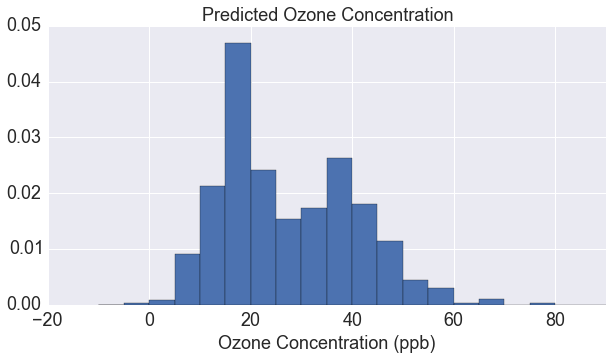

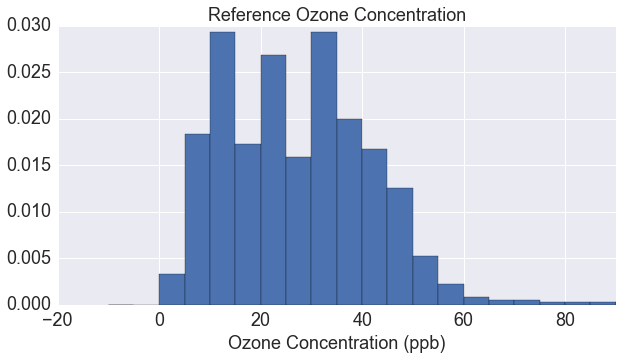

In [24]:
plot_hist(X_pred_cv_all, y_cv, 'Predicted Ozone Concentration')
plot_hist(y_cv, X_pred_cv_all, 'Reference Ozone Concentration')

###Plot the residuals and comparison curves.

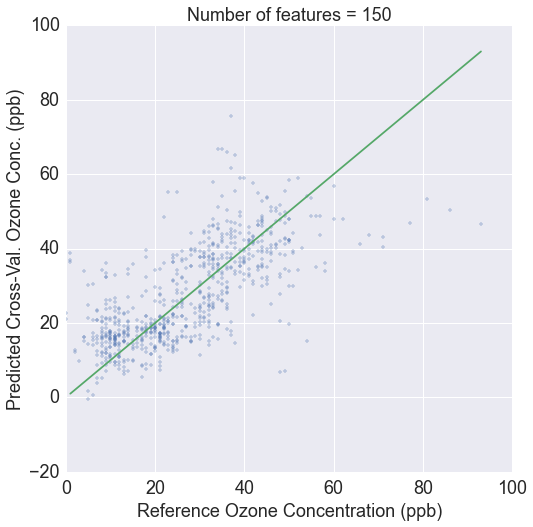

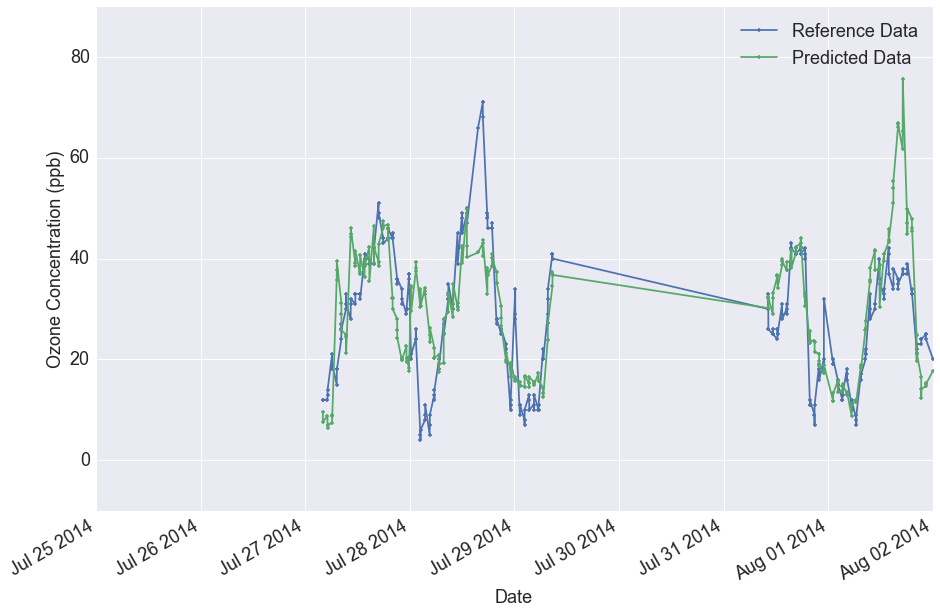

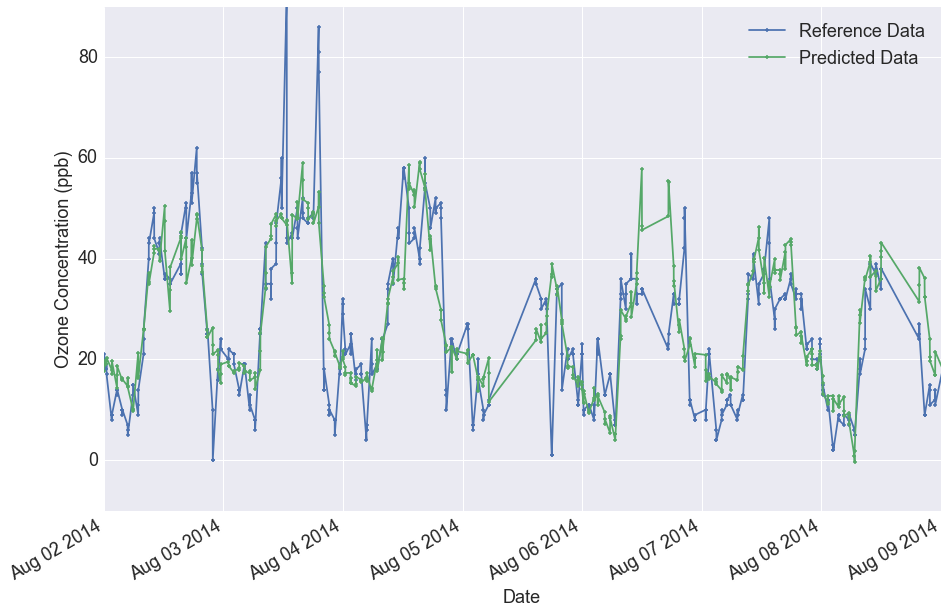

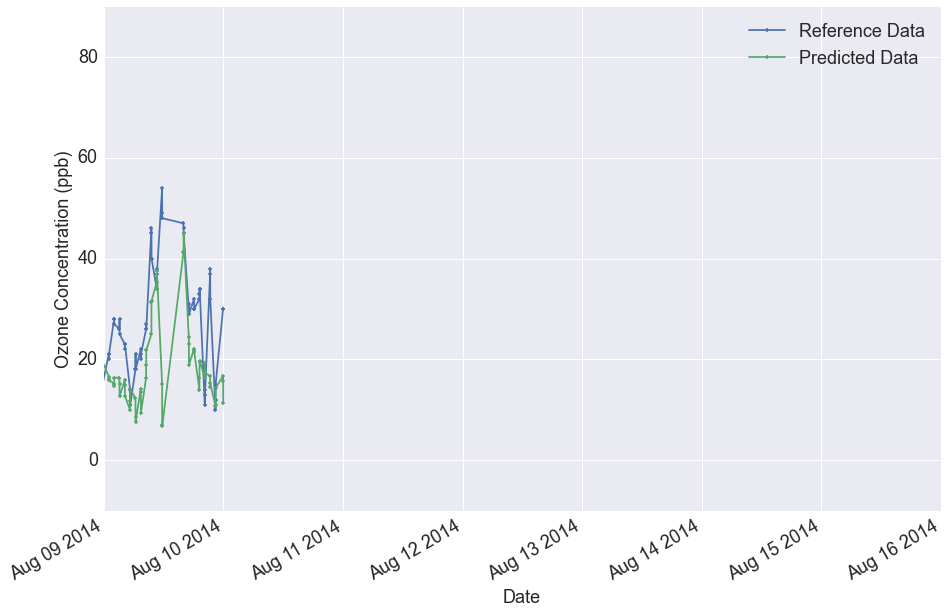

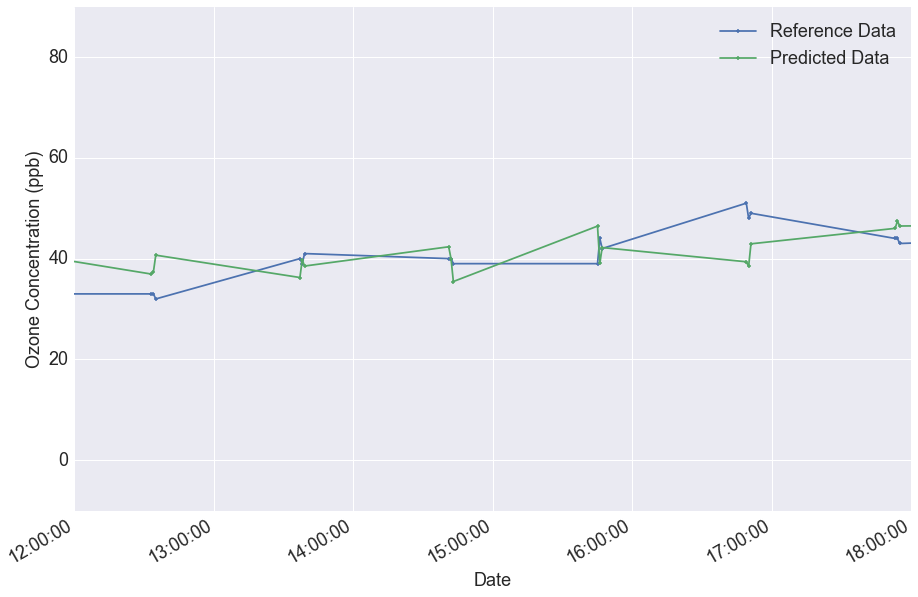

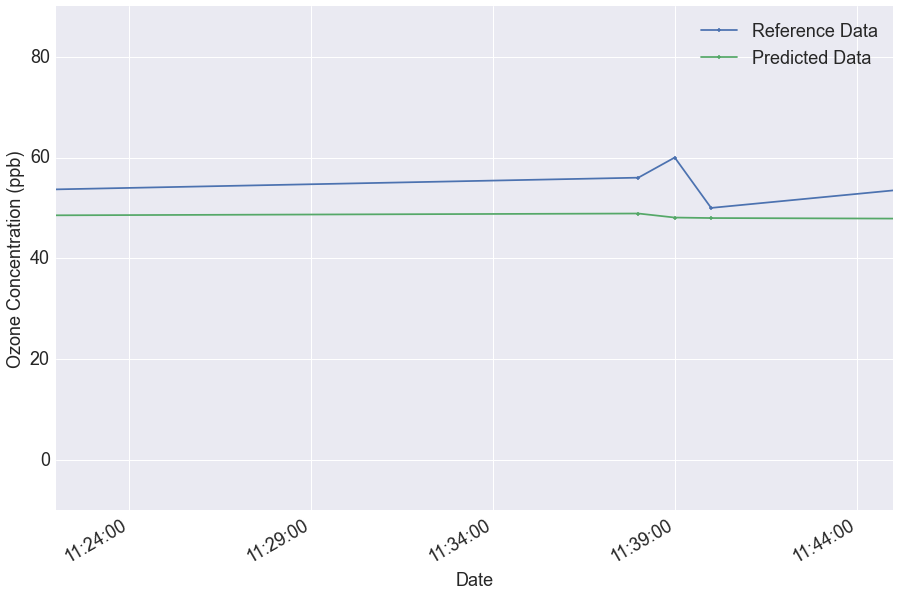

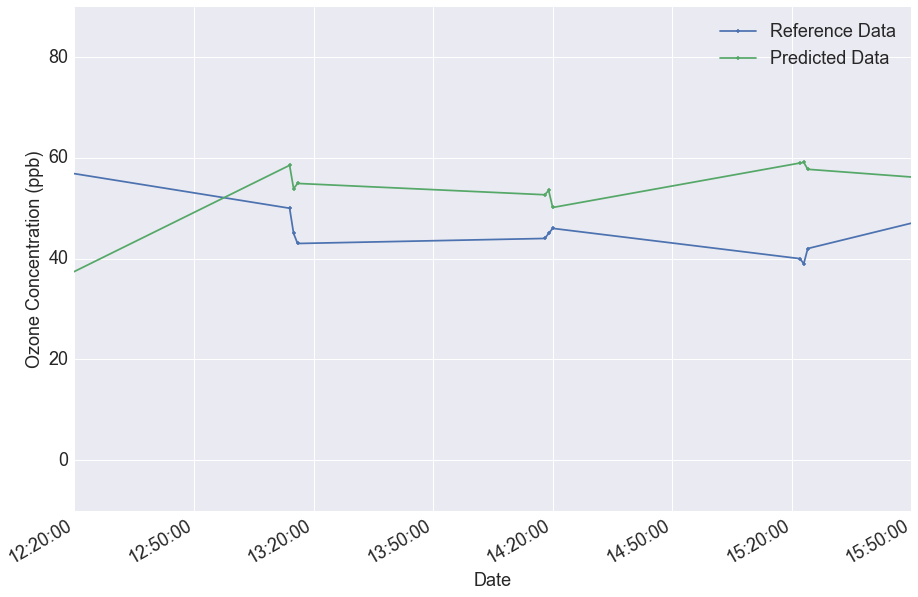

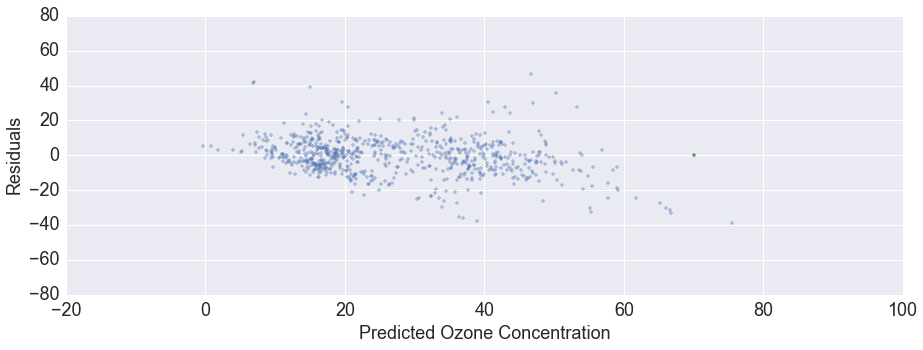

In [ ]:
num_good_feat = len(all_features)
fitted_vs_ref_plot(df_cv_lin_all, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_all, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_all, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_all, pod_number, 3, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_all, pod_number, 4, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_all, pod_number, 5, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_all, pod_number, 6, ref_column)
resid = plot_resid_vs_conc(df_cv_lin_all, ref_column)

#Forward Selection

####Declare rather you want to use MSE or a custom error function:

In [ ]:
#make a list of features from the column titles in the dataframe
features_all = list(df_tr.columns)
leave_out = ['Zenith Angle [degrees]','UnixTime', 'pod_o3_smooth', 'O3_ppb', 'ref_o3_smooth', ref_column, 'chunk']
features = [f for f in features_all if f not in leave_out]
features_it = [f for f in features if f not in 'day']
fs_features, score, RMSE = forward_selection_lodo(lin_regr, features_it, df_tr[[ref_column] + features].dropna(), 'custom_mse', ref_column, days_tr, 15, cust_mse_fact, cutoff_value)

9223372036854775807
Next best Feature:  ln_temp_int_lag_4 , Score:  10.5 RMSE:  3.2 #: 1
9223372036854775807
Next best Feature: 

In [ ]:
plot_error_vs_features(score, RMSE, [0,20], [1,35])

#Check Residuals

###Plot cross-validation fitted data versus reference data, and choose number of features.

In [88]:
df_tr['d']

KeyError: 'd'

In [90]:
i = 1
while i < 15:
    num_good_feat = i
    df_cv_1, df_H_1 = find_fitted_cv_values_for_best_features(df_tr, df_hold, fs_features, num_good_feat, linear_model.LinearRegression(), chunks_tr, ref_column)
    fitted_vs_ref_plot(df_cv_1, i, ref_column) 
    plot_learning_curve(lin_regr, "Learning Curve- Number of features = " + str(i), df_tr[fs_features[:i]].values, df_tr[ref_column].values, (0,15), 5, np.array([0.1, 0.3, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95,0.97, 1.0]))
    i += 2

7-27 AM                      UnixTime     e2v03       no2      Temp        Rh  \
2014-07-27 04:03:00 -1.836904 -1.113736 -0.951663 -1.131972  1.622360   
2014-07-27 04:04:00 -1.836744 -1.114700 -0.949138 -1.131972  1.622452   
2014-07-27 05:06:00 -1.826787 -1.129016 -0.941566 -1.121781  1.582450   
2014-07-27 05:07:00 -1.826627 -1.134384 -0.946226 -1.125130  1.587639   
2014-07-27 05:08:00 -1.826461 -1.132733 -0.959429 -1.126840  1.602520   

                     days from start   O3_sqrt     O3_sq     O3_cu     ln_O3  \
2014-07-27 04:03:00        -1.820577 -1.174344 -0.997644 -0.890831 -1.236085   
2014-07-27 04:04:00        -1.820577 -1.175490 -0.998308 -0.891272 -1.237434   
2014-07-27 05:06:00        -1.820577 -1.192526 -1.008146 -0.897795 -1.257526   
2014-07-27 05:07:00        -1.820577 -1.198924 -1.011825 -0.900227 -1.265083   
2014-07-27 05:08:00        -1.820577 -1.196955 -1.010693 -0.899480 -1.262757   

                      ...     ln_rh_slope_lag_4  ln_rh_slope_lag_5  \
20

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

###Enter the chosen number of features, and perform a linear regression.

In [361]:
num_good_feat = 10
best_features = fs_features[:num_good_feat]
MSE_CV, MSE_T, MSE_H, high_MSE_cv, X_pred_cv_best, y_cv_best, df_cv_lin_best, df_H_lin_best = cross_validation_by_day(lin_regr, best_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 7.8
Cross-Validation RMSE: 9.0 , High-Value CV RMSE: 13.0 , CV High Diff. in Mean (>50): -10.2
Holdout RMSE: 10.0 , High-Value Holdout RMSE: 21.0 , Holdout High Diff. in Mean.: -18.3


####Print Best Features

In [362]:
best_features

['ln_rh_int_lag_2',
 'Temp_slope_lead_1',
 'ln_O3_slope_lead_1',
 '03_sq_mult_rh_sq',
 'Temp_slope_lag_1',
 'e2v03_slope_lag_4',
 'Temp_slope_lag_4',
 'ln_rh_slope_lag_4',
 'ln_temp_slope_lead_2',
 'ln_temp_slope_lag_1']

### Plot the cross-validation data and residuals below.

In [363]:
ref_column

'O3_ppb'

In [364]:
df_lin_regr_best_feat_cv, df_lin_regr_best_feat_H  = find_fitted_cv_values_for_best_features(df_tr, df_hold, fs_features, num_good_feat, linear_model.LinearRegression(), chunks_tr, ref_column)
fitted_vs_ref_plot(df_lin_regr_best_feat_cv, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat_cv, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat_cv, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat_cv, pod_number, 3, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat_cv, pod_number, 4, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat_cv, pod_number, 5, ref_column)
resid = plot_resid_vs_conc(df_lin_regr_best_feat_cv, ref_column)

ValueError: Found array with 0 sample(s) (shape=(0, 10)) while a minimum of 1 is required.

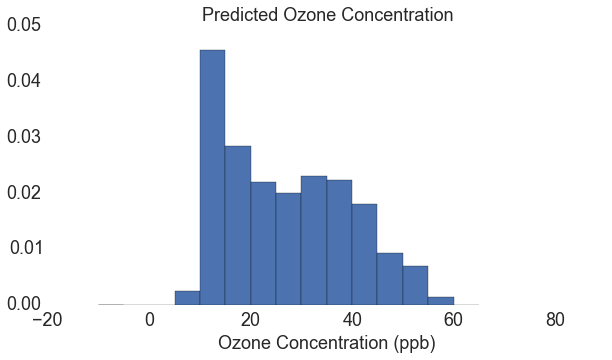

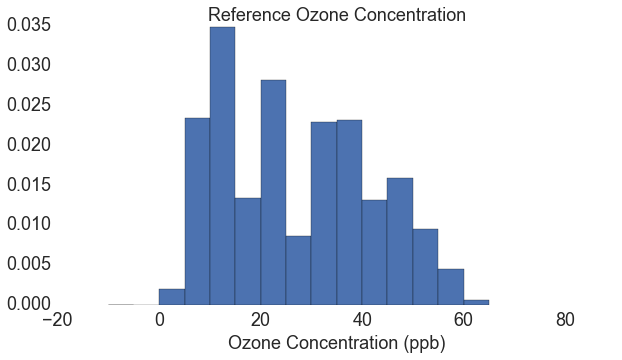

In [365]:
plot_hist(X_pred_cv_best, y_cv_best, 'Predicted Ozone Concentration')
plot_hist(y_cv_best, X_pred_cv_best, 'Reference Ozone Concentration')

#Ridge Regression- All Features

In [366]:
fs_features = all_features
num_good_feat_ridge = len(all_features)

In [367]:
#define the training data
df_fits = df_tr[fs_features[:num_good_feat_ridge] + [ref_column] + ['day']].dropna()
X = df_scaled[fs_features[:num_good_feat_ridge]].values
y = df_scaled[ref_column].values

###Find the best lambda value using cross-validation

In [368]:
best_lambda_ridge, lambda_ridge, coefs, mean_score_lambda = find_best_lambda(Ridge, fs_features[:num_good_feat_ridge], df_fits, ref_column, 'custom_mse_scoring_function', days_tr, X, y, 0.0000001, 1000000, 3, cust_mse_fact, cutoff_value)

lambda: 1e-07
score: 20.97
lambda: 3e-07
score: 20.97
lambda: 9e-07
score: 20.86
lambda: 2.7e-06
score: 20.76
lambda: 8.1e-06
score: 20.71
lambda: 2.43e-05
score: 20.72
lambda: 7.29e-05
score: 20.92
lambda: 0.0002187
score: 20.84
lambda: 0.0006561
score: 21.07
lambda: 0.0019683
score: 21.77
lambda: 0.0059049
score: 22.64
lambda: 0.0177147
score: 22.97
lambda: 0.0531441
score: 22.46
lambda: 0.1594323
score: 21.6
lambda: 0.4782969
score: 20.91
lambda: 1.4348907
score: 20.53
lambda: 4.3046721
score: 20.63
lambda: 12.9140163
score: 21.14
lambda: 38.7420489
score: 21.99
lambda: 116.2261467
score: 22.74
lambda: 348.6784401
score: 23.33
lambda: 1046.0353203
score: 24.09
lambda: 3138.1059609
score: 25.32
lambda: 9414.3178827
score: 27.89
lambda: 28242.9536481
score: 32.79
lambda: 84728.8609443
score: 38.99
lambda: 254186.582833
score: 43.59
lambda: 762559.748499
score: 45.83
Best Lambda: 1.4348907


###Plot the values of lambda versus the coefficients and the custom score. 

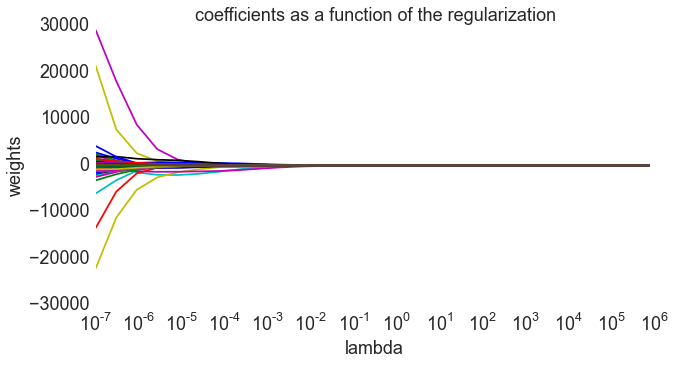

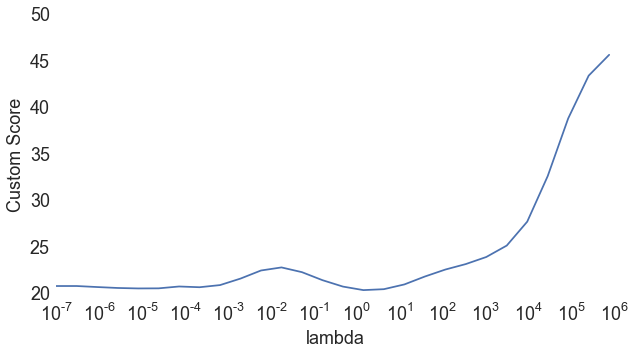

In [369]:
plot_lambda(lambda_ridge, coefs, mean_score_lambda)

####Use the best lambda value found above to find errors.

In [370]:
MSE_CV_ridge, MSE_T_ridge, MSE_H_ridge, high_MSE_cv_ridge, X_pred_cv_ridge, y_cv_ridge, df_cv_ridge, df_H_ridge = cross_validation_by_day(Ridge(alpha = best_lambda_ridge), all_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 7.3
Cross-Validation RMSE: 9.0 , High-Value CV RMSE: 14.0 , CV High Diff. in Mean (>50): -11.8
Holdout RMSE: 9.0 , High-Value Holdout RMSE: 19.0 , Holdout High Diff. in Mean.: -16.8


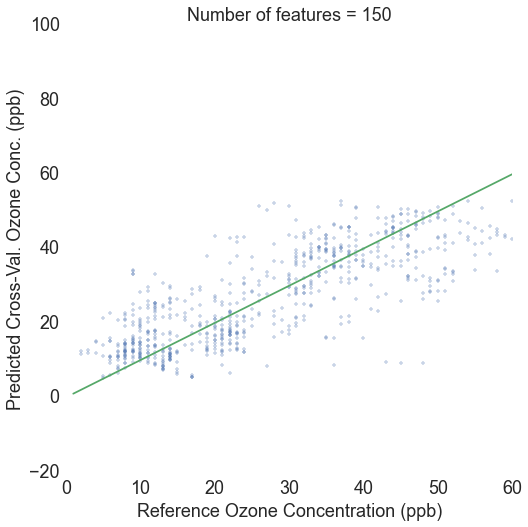

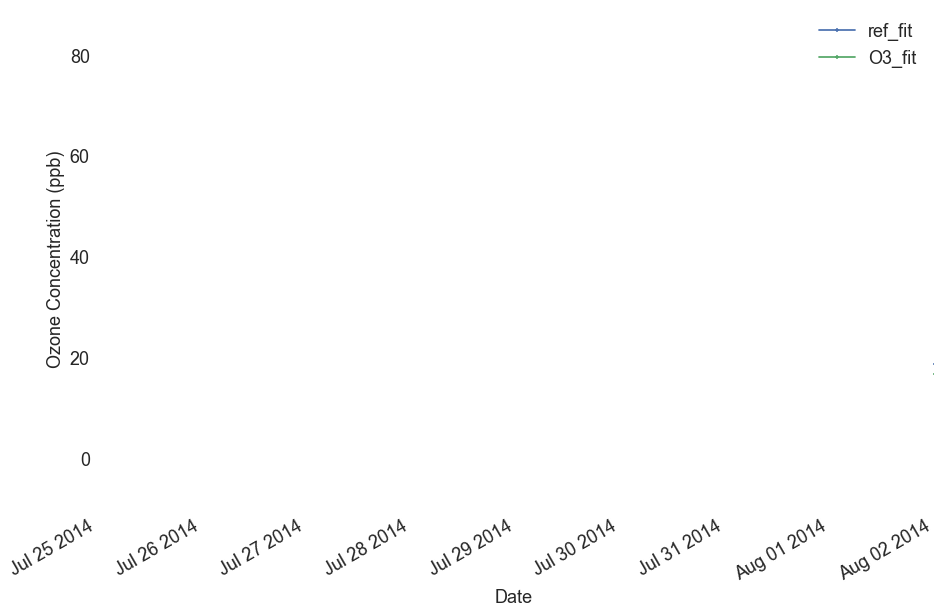

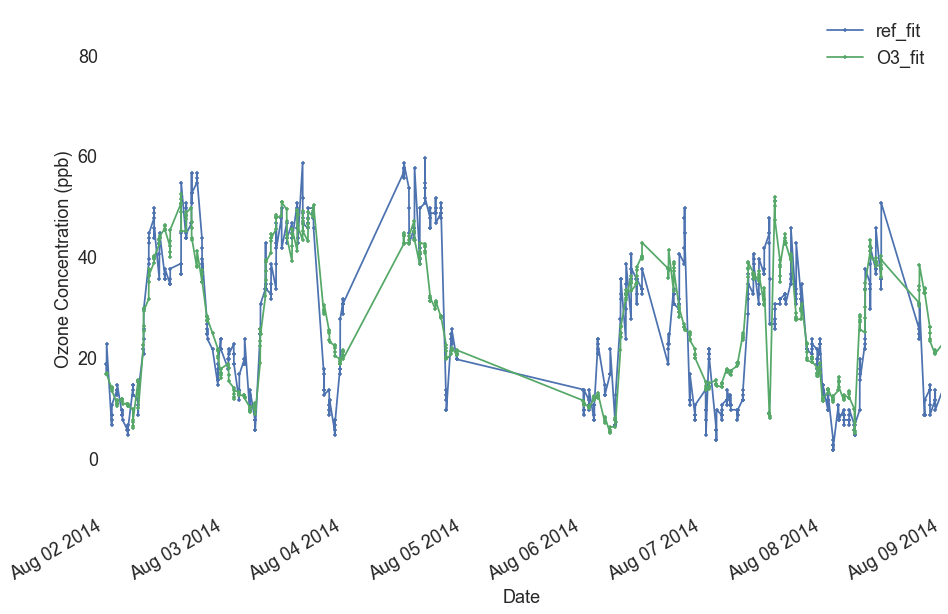

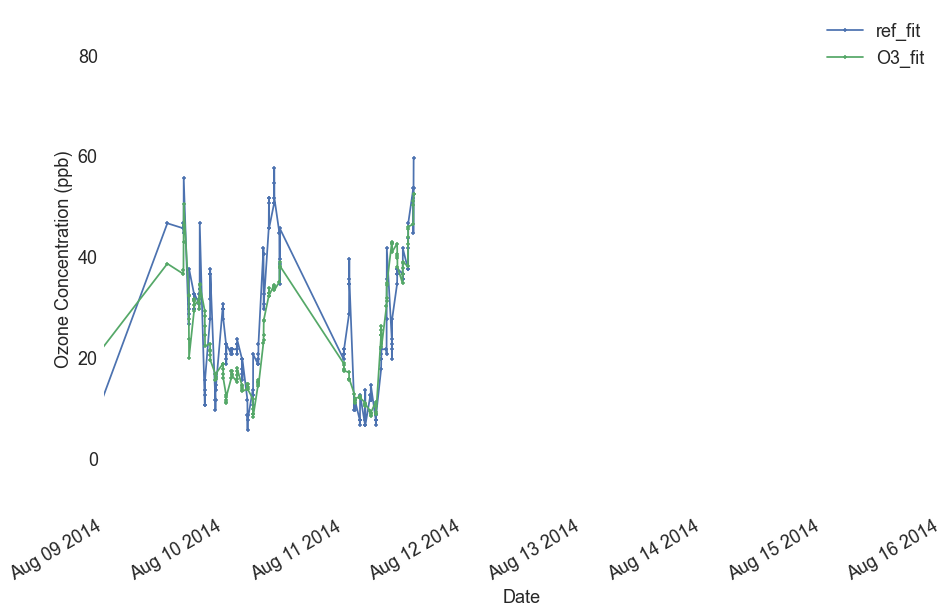

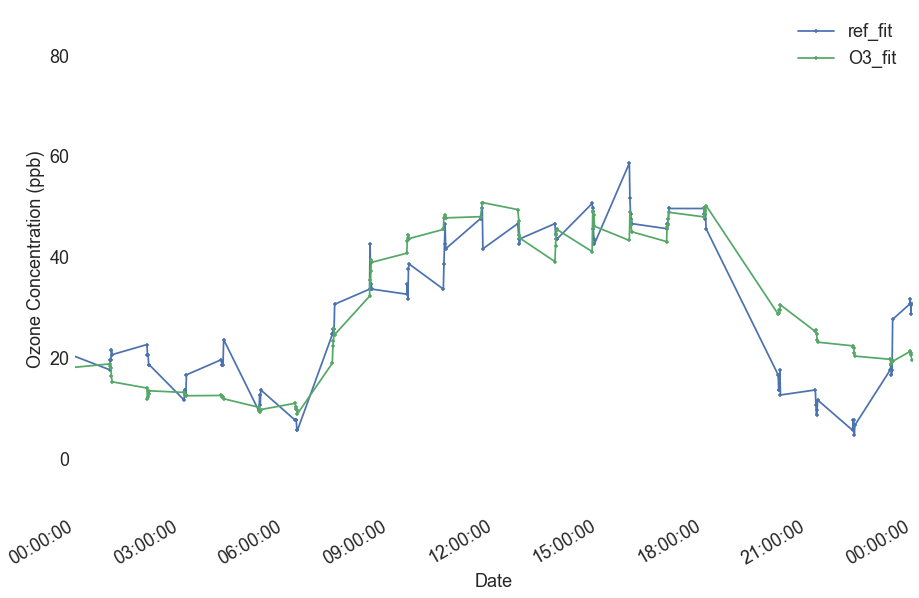

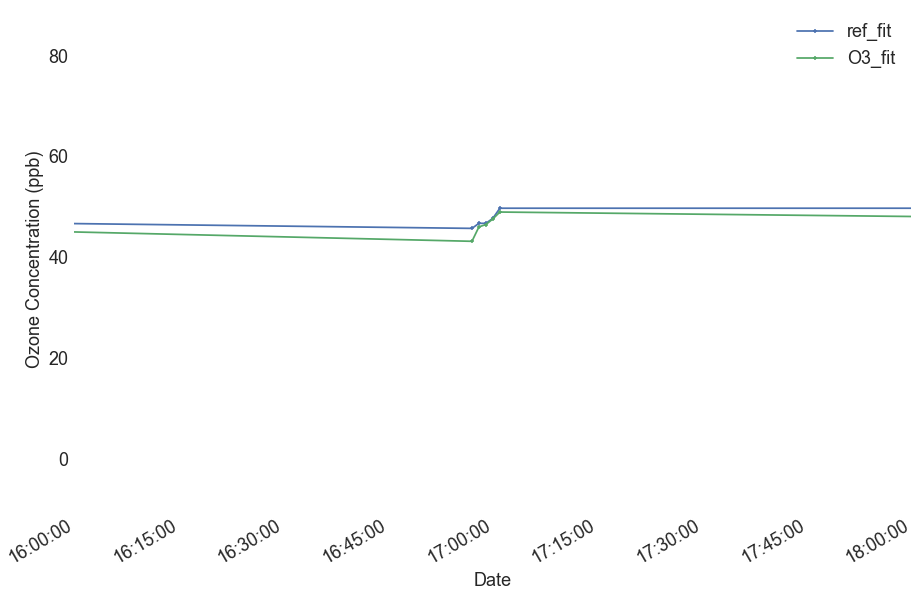

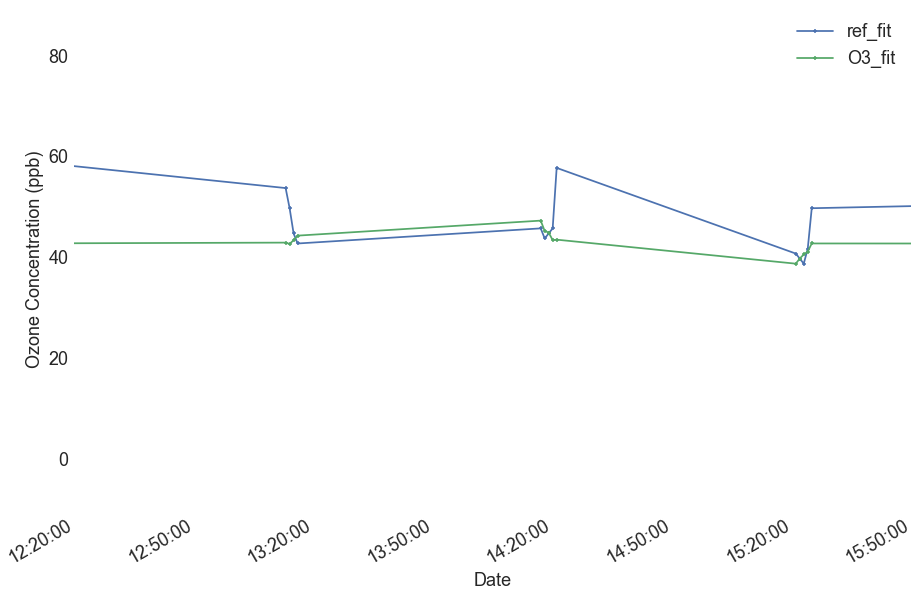

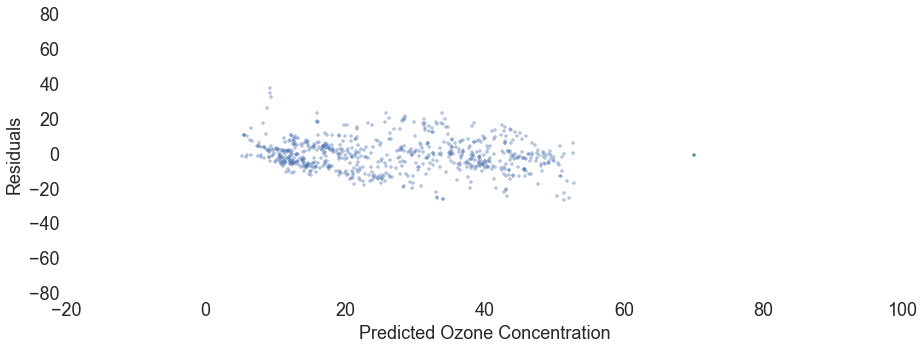

In [371]:
fitted_vs_ref_plot(df_cv_ridge, num_good_feat_ridge, ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge, pod_number, 3, ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge, pod_number, 4, ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge, pod_number, 5, ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge, pod_number, 6, ref_column)
resid = plot_resid_vs_conc(df_cv_ridge, ref_column)

#Ridge Regression- Best Features

In [372]:
#define the training data
df_fits_best = df_tr[best_features + [ref_column] + ['day']].dropna()
X = df_scaled[best_features].values
y = df_scaled[ref_column].values

In [373]:
best_lambda_ridge_best, lambda_ridge_best, coefs_best, mean_score_lambda_best = find_best_lambda(Ridge, best_features, df_fits_best, ref_column, 'custom_mse_scoring_function', days_tr, X, y, 0.0000001, 1000000, 3, cust_mse_fact, cutoff_value)

lambda: 1e-07
score: 16.87
lambda: 3e-07
score: 16.87
lambda: 9e-07
score: 16.87
lambda: 2.7e-06
score: 16.87
lambda: 8.1e-06
score: 16.87
lambda: 2.43e-05
score: 16.87
lambda: 7.29e-05
score: 16.87
lambda: 0.0002187
score: 16.87
lambda: 0.0006561
score: 16.87
lambda: 0.0019683
score: 16.87
lambda: 0.0059049
score: 16.88
lambda: 0.0177147
score: 16.88
lambda: 0.0531441
score: 16.9
lambda: 0.1594323
score: 16.94
lambda: 0.4782969
score: 17.08
lambda: 1.4348907
score: 17.47
lambda: 4.3046721
score: 18.42
lambda: 12.9140163
score: 20.31
lambda: 38.7420489
score: 22.72
lambda: 116.2261467
score: 25.22
lambda: 348.6784401
score: 28.79
lambda: 1046.0353203
score: 34.46
lambda: 3138.1059609
score: 40.56
lambda: 9414.3178827
score: 44.45
lambda: 28242.9536481
score: 46.18
lambda: 84728.8609443
score: 46.81
lambda: 254186.582833
score: 47.03
lambda: 762559.748499
score: 47.11
Best Lambda: 1e-07


###Plot the values of lambda versus the coefficients and the custom score. 


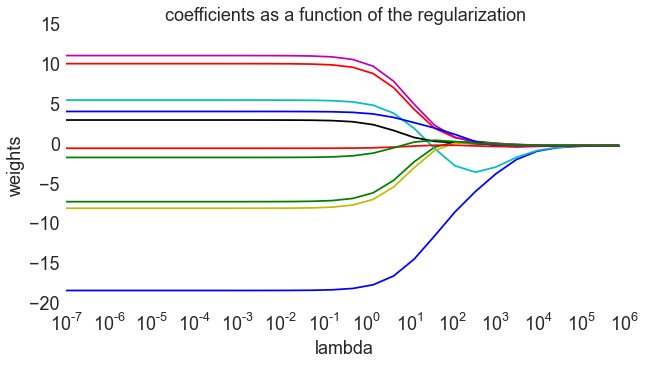

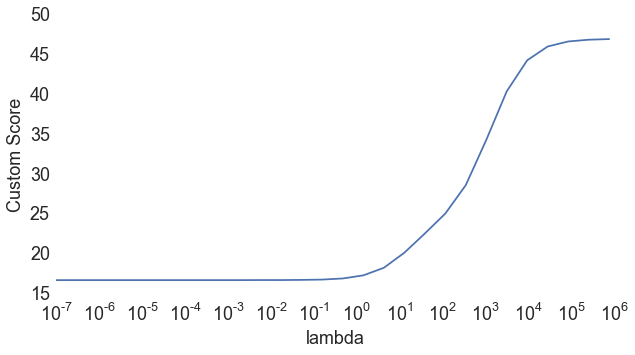

In [374]:
plot_lambda(lambda_ridge_best, coefs_best, mean_score_lambda_best)

####Use the best lambda value found above to find errors.

In [375]:
MSE_CV_ridge_best, MSE_T_ridge_best, MSE_H_ridge_best, high_MSE_cv_ridge_best, X_pred_cv_ridge_best, y_cv_ridge_best, df_cv_ridge_best, df_H_ridge_best = cross_validation_by_day(Ridge(alpha = best_lambda_ridge_best), best_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 7.8
Cross-Validation RMSE: 9.0 , High-Value CV RMSE: 13.0 , CV High Diff. in Mean (>50): -10.2
Holdout RMSE: 10.0 , High-Value Holdout RMSE: 21.0 , Holdout High Diff. in Mean.: -18.3


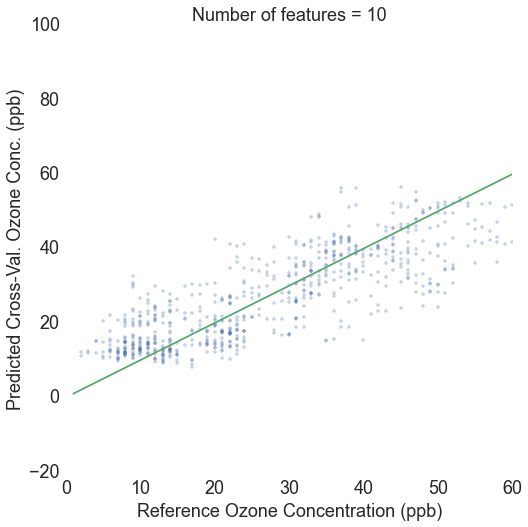

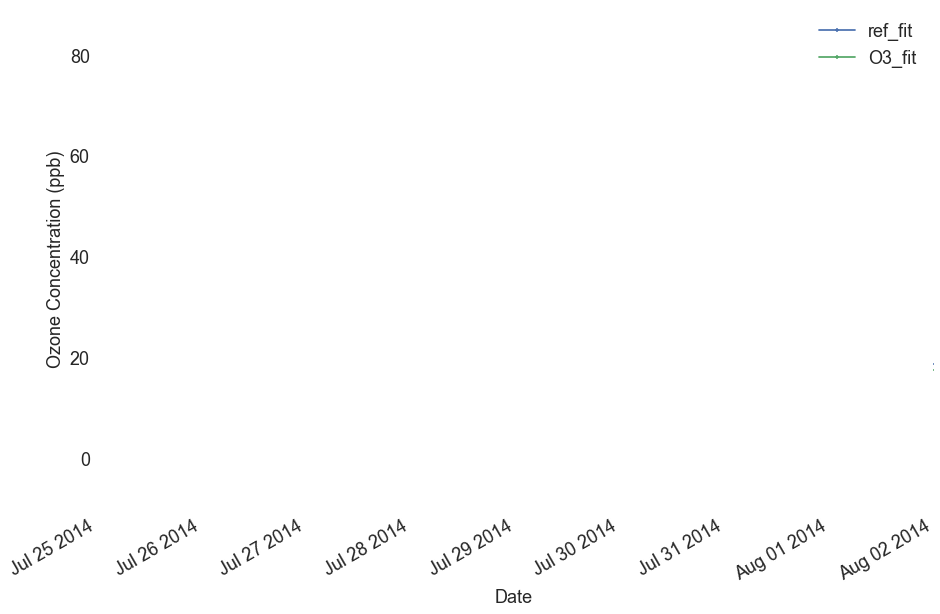

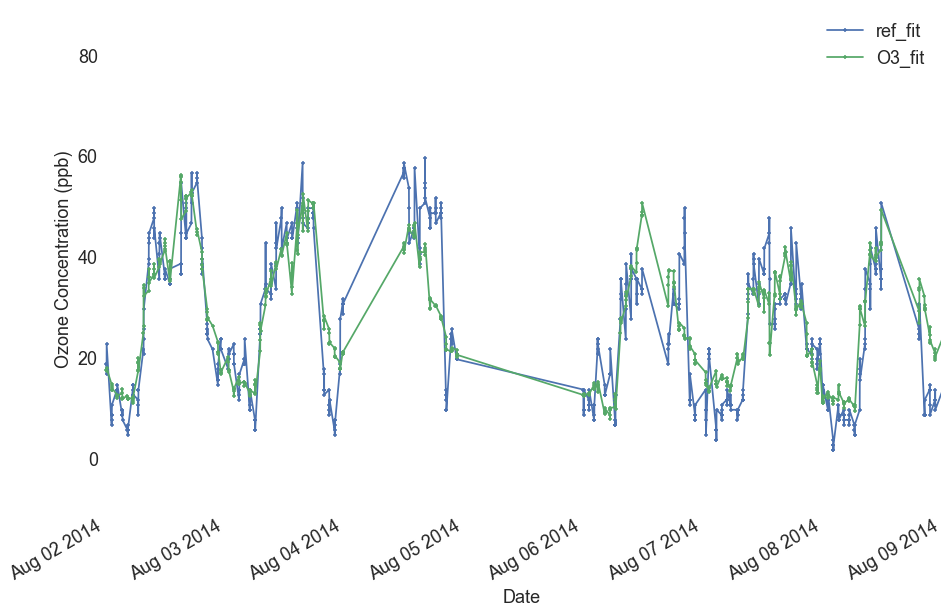

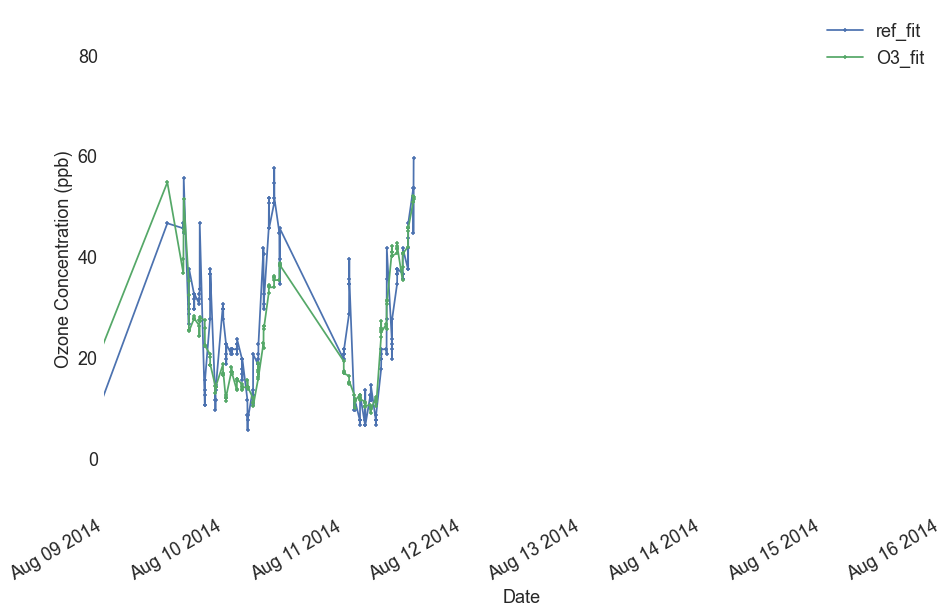

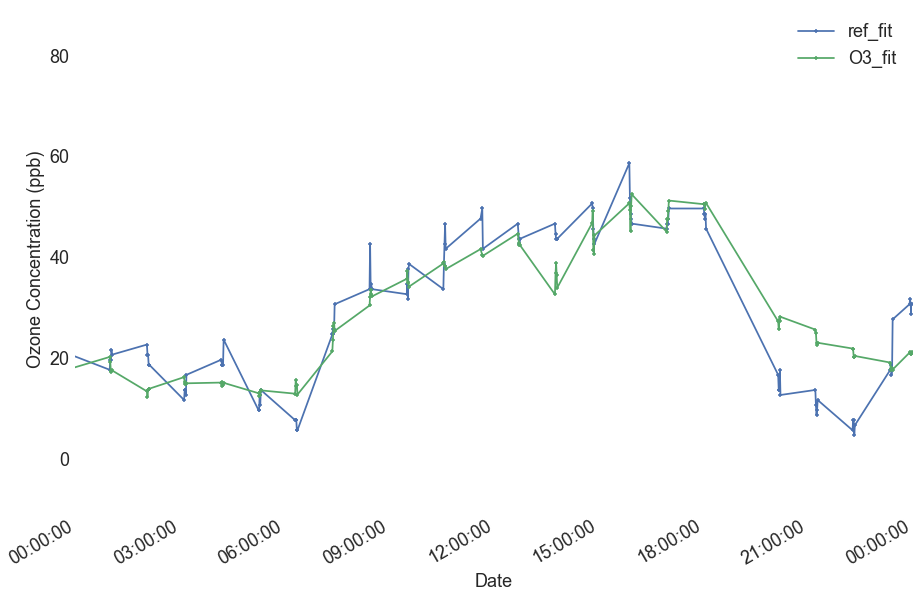

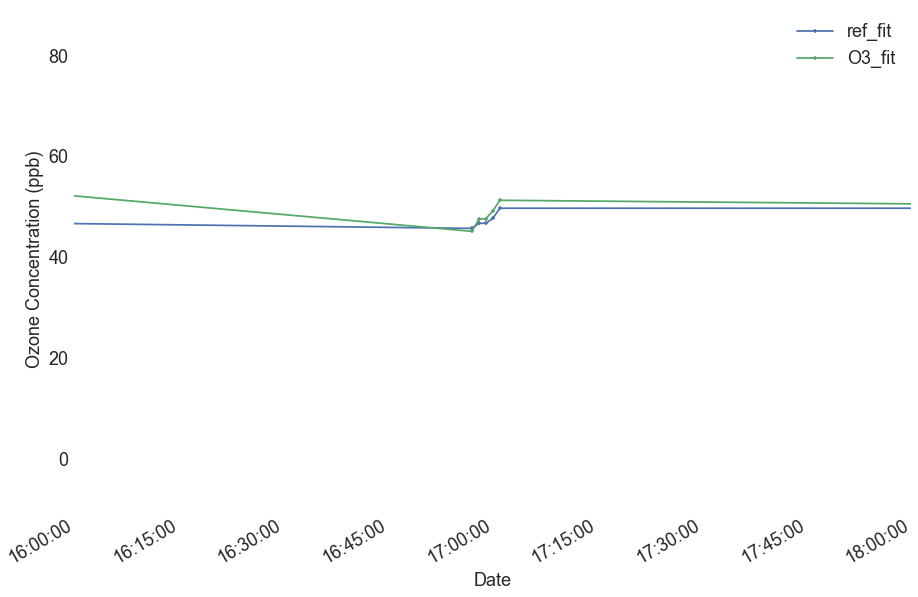

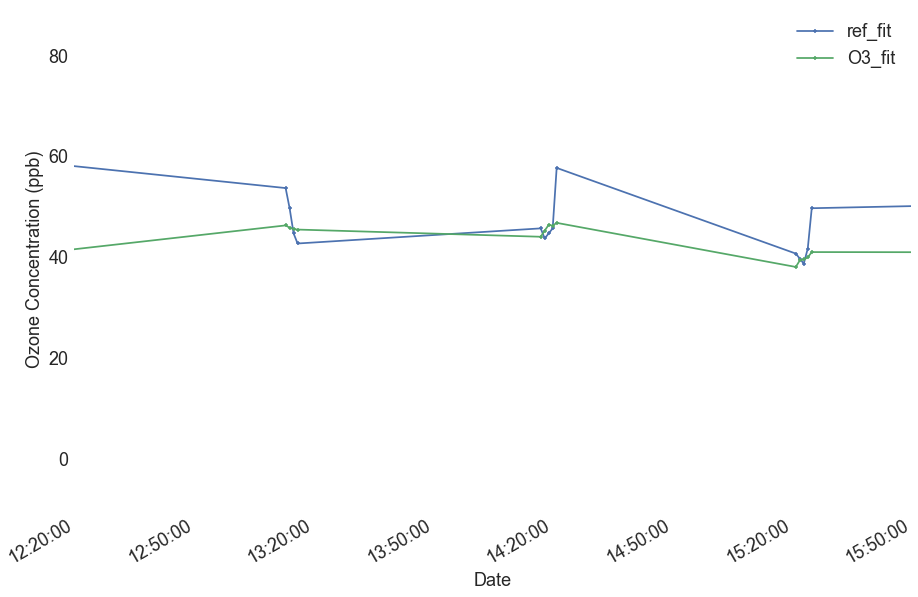

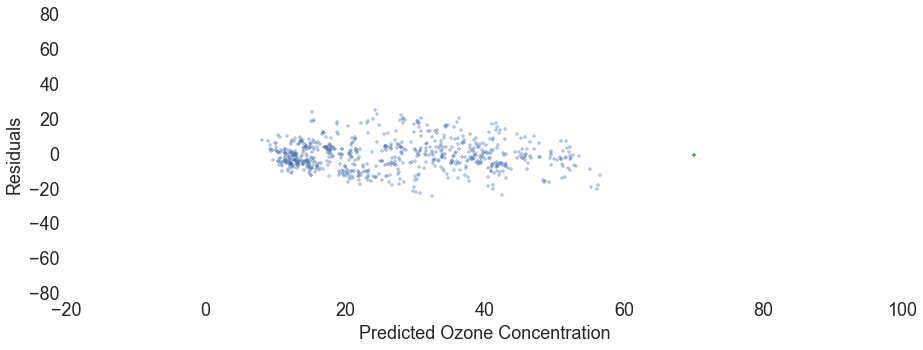

In [376]:
fitted_vs_ref_plot(df_cv_ridge_best, len(best_features), ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge_best, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge_best, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge_best, pod_number, 3, ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge_best, pod_number, 4, ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge_best, pod_number, 5, ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge_best, pod_number, 6, ref_column)
resid = plot_resid_vs_conc(df_cv_ridge_best, ref_column)

#Lasso- All Features

In [377]:
best_lambda_lasso, lambda_lasso, coefs_lasso, mean_score_lambda_lasso = find_best_lambda(Lasso, fs_features[:num_good_feat_ridge], df_fits, ref_column, 'custom_mse_scoring_function', days_tr, X, y, 0.000001, 100, 3, cust_mse_fact, cutoff_value)

lambda: 1e-06
score: 20.75
lambda: 3e-06
score: 20.75
lambda: 9e-06
score: 20.75
lambda: 2.7e-05
score: 20.75
lambda: 8.1e-05
score: 20.75
lambda: 0.000243
score: 20.75
lambda: 0.000729
score: 20.73
lambda: 0.002187
score: 20.62
lambda: 0.006561
score: 20.96
lambda: 0.019683
score: 21.07
lambda: 0.059049
score: 22.28
lambda: 0.177147
score: 23.92
lambda: 0.531441
score: 24.51
lambda: 1.594323
score: 26.96
lambda: 4.782969
score: 33.46
lambda: 14.348907
score: 47.15
lambda: 43.046721
score: 47.15
Best Lambda: 0.002187


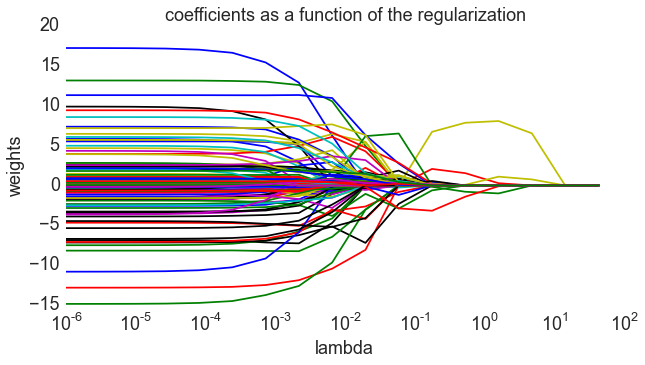

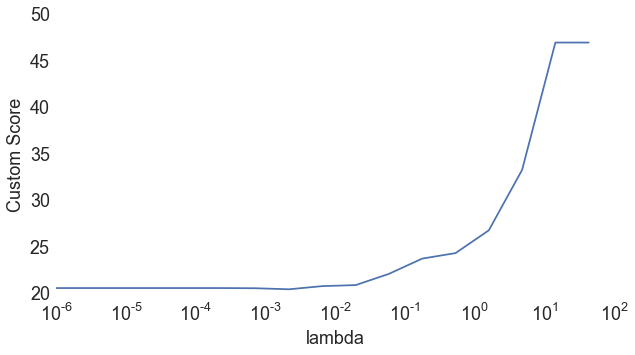

In [378]:
plot_lambda(lambda_lasso, coefs_lasso, mean_score_lambda_lasso)

####Use the best lambda value found above to find holdout values.

In [379]:
MSE_CV_lasso, MSE_T_lasso, MSE_H_lasso, high_MSE_cv_lasso, X_pred_cv_lasso, y_cv_lasso, df_cv_lasso, df_H_lasso = cross_validation_by_day(Lasso(alpha = best_lambda_lasso), all_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 7.2
Cross-Validation RMSE: 9.0 , High-Value CV RMSE: 14.0 , CV High Diff. in Mean (>50): -11.7
Holdout RMSE: 9.0 , High-Value Holdout RMSE: 18.0 , Holdout High Diff. in Mean.: -16.1


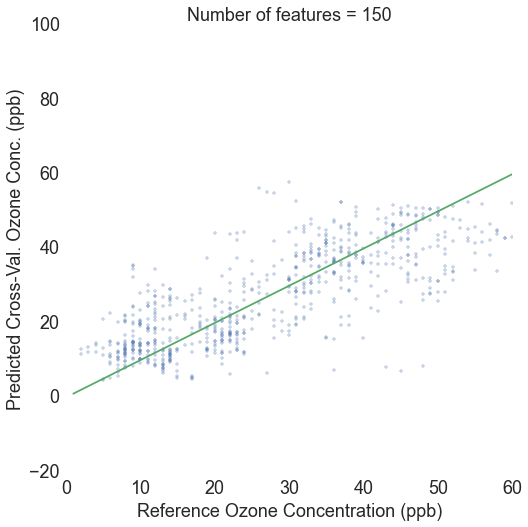

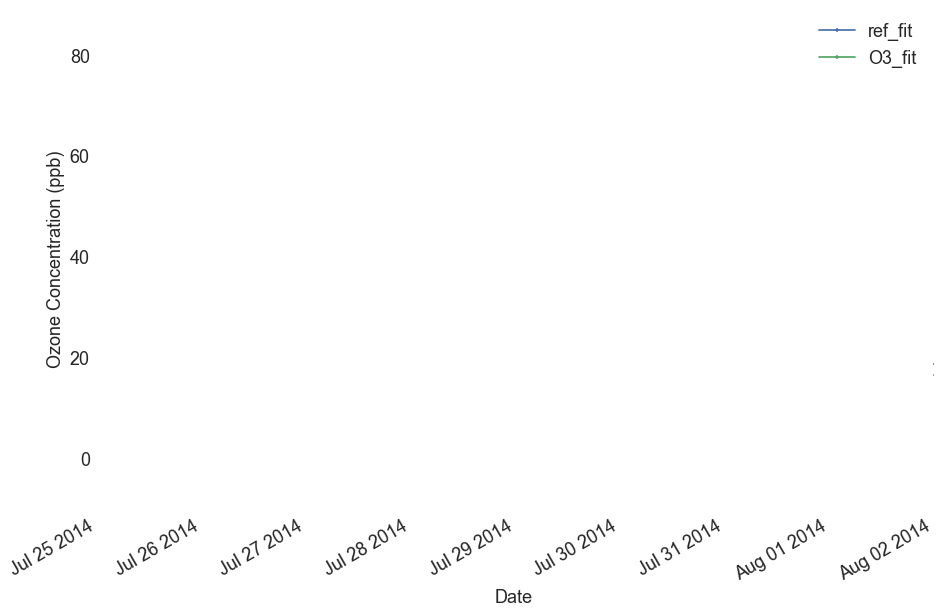

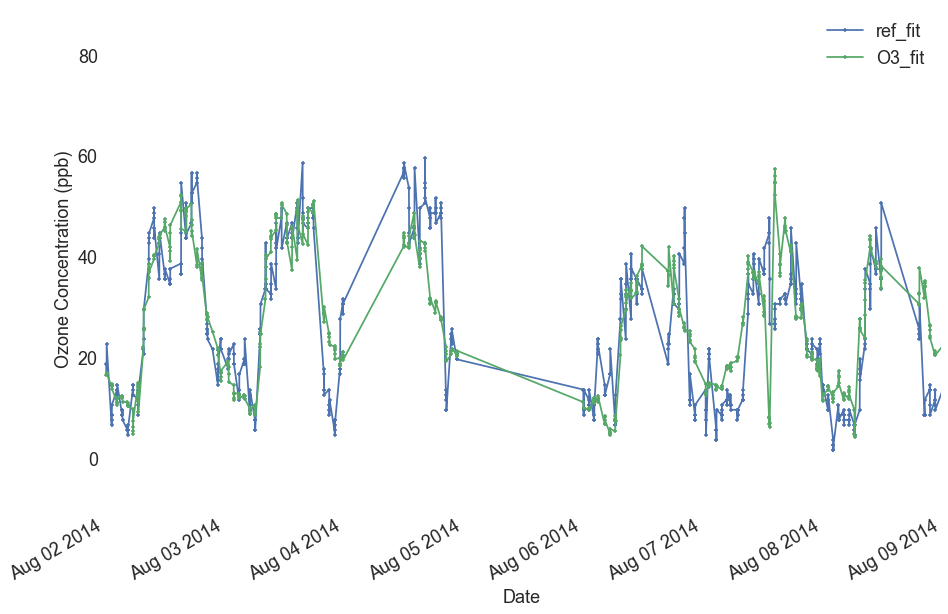

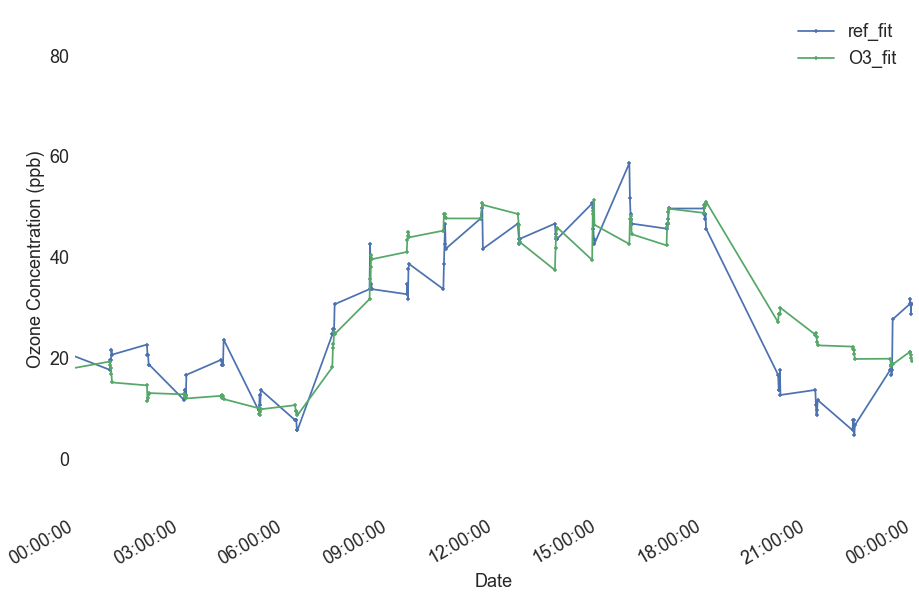

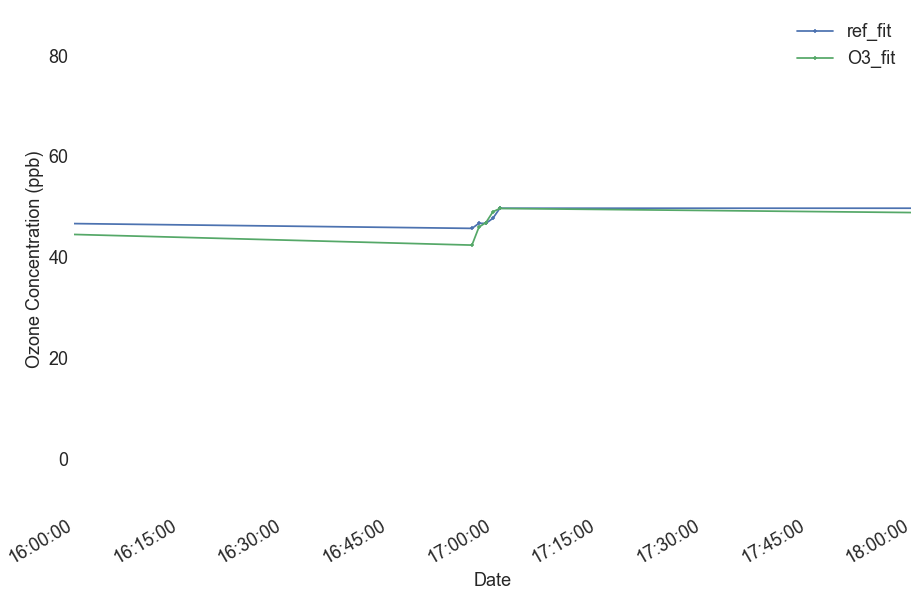

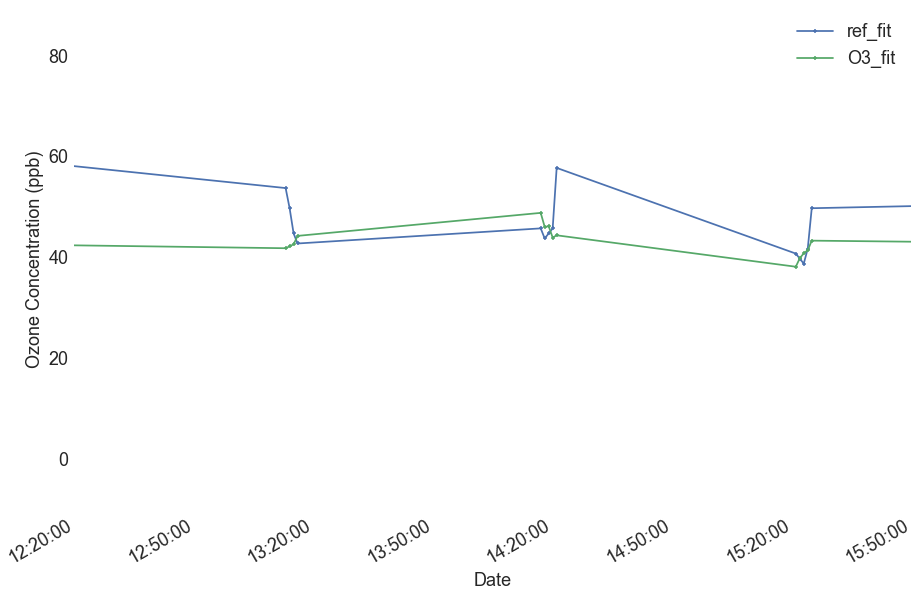

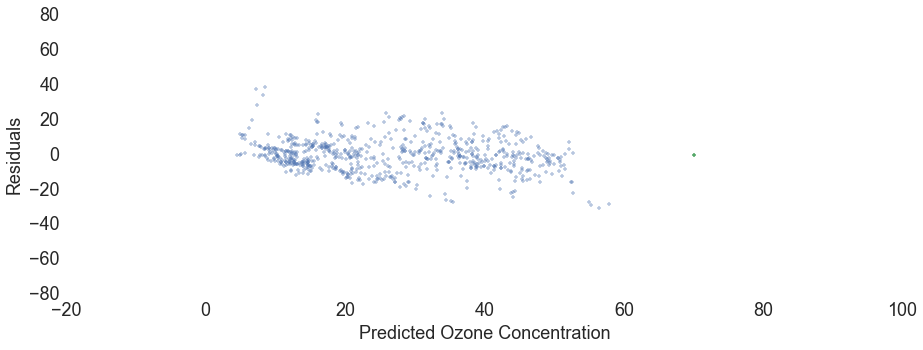

In [380]:
fitted_vs_ref_plot(df_cv_lasso, num_good_feat_ridge, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lasso, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lasso, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lasso, pod_number, 4, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lasso, pod_number, 5, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lasso, pod_number, 6, ref_column)
resid = plot_resid_vs_conc(df_cv_lasso, ref_column)

#Lasso- Best Features

In [381]:
best_lambda_lasso_best, lambda_lasso_best, coefs_lasso_best, mean_score_lambda_lasso_best = find_best_lambda(Lasso, best_features, df_fits_best, ref_column, 'custom_mse_scoring_function', days_tr, X, y, 0.0000000000001, 100, 3, cust_mse_fact, cutoff_value)

lambda: 1e-13
score: 16.87
lambda: 3e-13
score: 16.87
lambda: 9e-13
score: 16.87
lambda: 2.7e-12
score: 16.87
lambda: 8.1e-12
score: 16.87
lambda: 2.43e-11
score: 16.87
lambda: 7.29e-11
score: 16.87
lambda: 2.187e-10
score: 16.87
lambda: 6.561e-10
score: 16.87
lambda: 1.9683e-09
score: 16.87
lambda: 5.9049e-09
score: 16.87
lambda: 1.77147e-08
score: 16.87
lambda: 5.31441e-08
score: 16.87
lambda: 1.594323e-07
score: 16.87
lambda: 4.782969e-07
score: 16.87
lambda: 1.4348907e-06
score: 16.87
lambda: 4.3046721e-06
score: 16.87
lambda: 1.29140163e-05
score: 16.87
lambda: 3.87420489e-05
score: 16.88
lambda: 0.0001162261467
score: 16.88
lambda: 0.0003486784401
score: 16.89
lambda: 0.0010460353203
score: 16.91
lambda: 0.0031381059609
score: 16.99
lambda: 0.0094143178827
score: 17.23
lambda: 0.0282429536481
score: 17.92
lambda: 0.0847288609443
score: 19.77
lambda: 0.254186582833
score: 21.92
lambda: 0.762559748499
score: 22.92
lambda: 2.2876792455
score: 26.65
lambda: 6.86303773649
score: 36.6


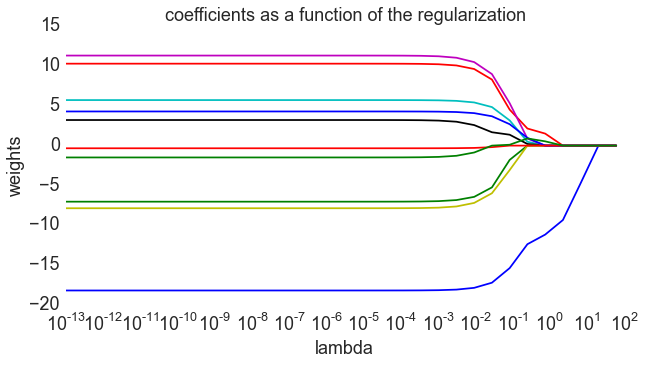

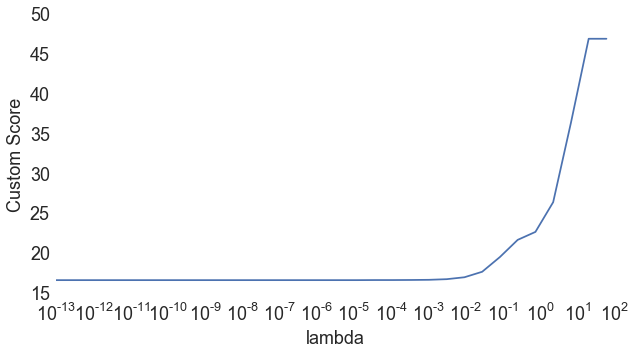

In [382]:
plot_lambda(lambda_lasso_best, coefs_lasso_best, mean_score_lambda_lasso_best)

In [383]:
MSE_CV_lasso_best, MSE_T_lasso_best, MSE_H_lasso_best, high_MSE_cv_lasso_best, X_pred_cv_lasso_best, y_cv_lasso, df_cv_lasso_best, df_H_lasso_best = cross_validation_by_day(Lasso(alpha = best_lambda_lasso), best_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 7.8
Cross-Validation RMSE: 9.0 , High-Value CV RMSE: 13.0 , CV High Diff. in Mean (>50): -10.3
Holdout RMSE: 10.0 , High-Value Holdout RMSE: 21.0 , Holdout High Diff. in Mean.: -18.3


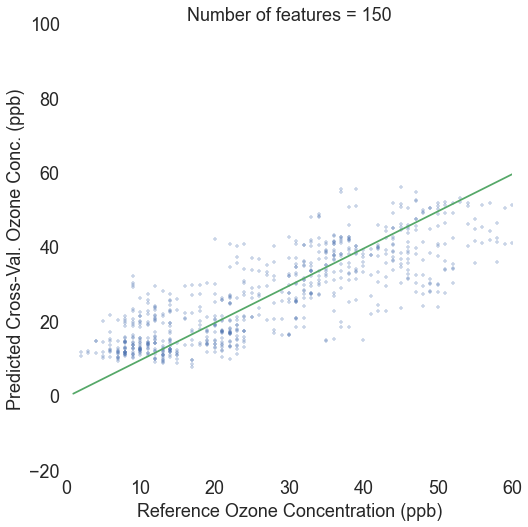

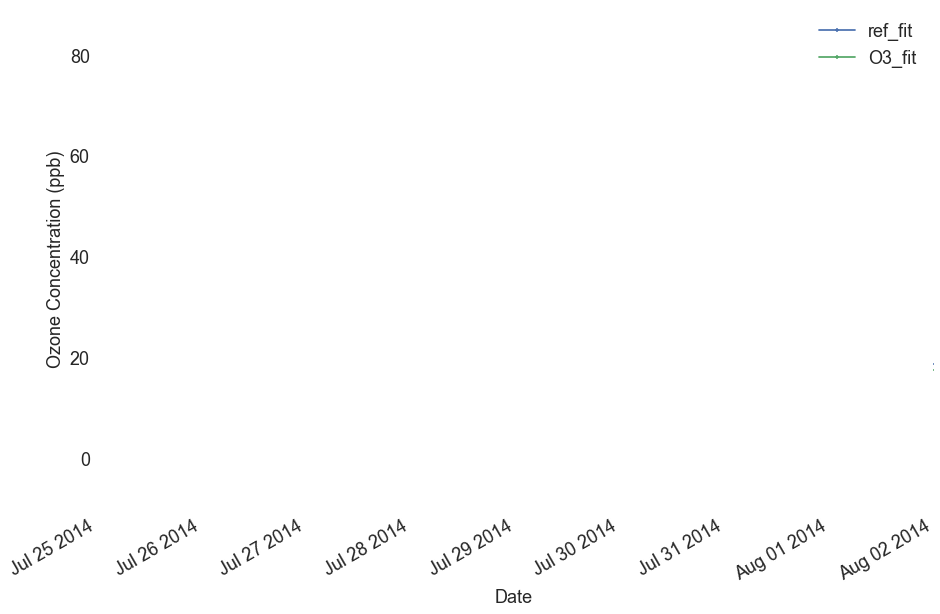

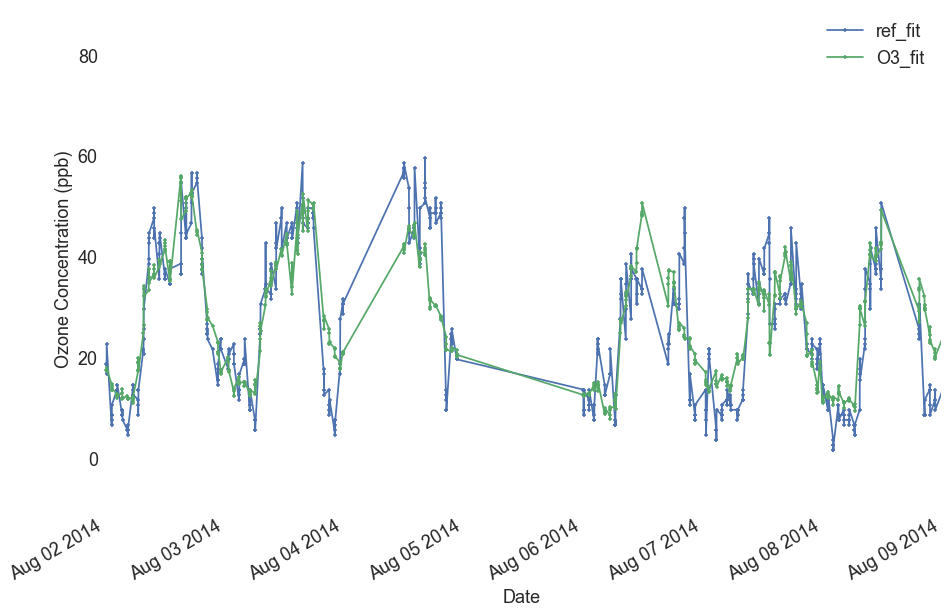

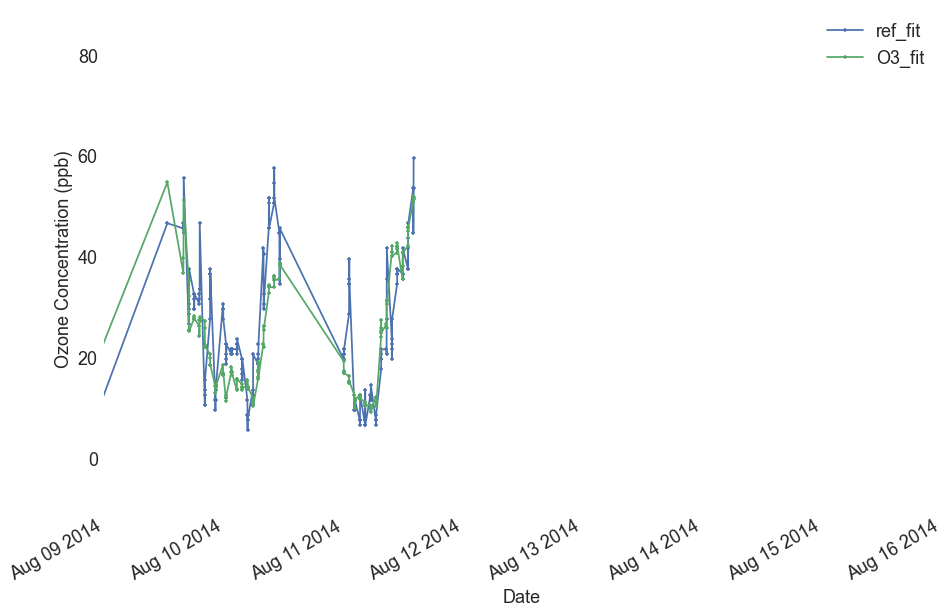

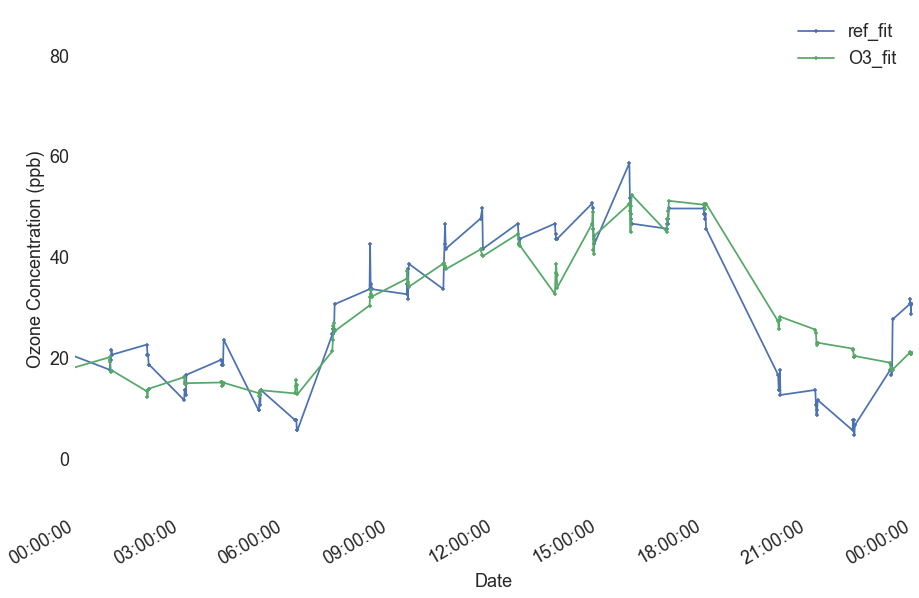

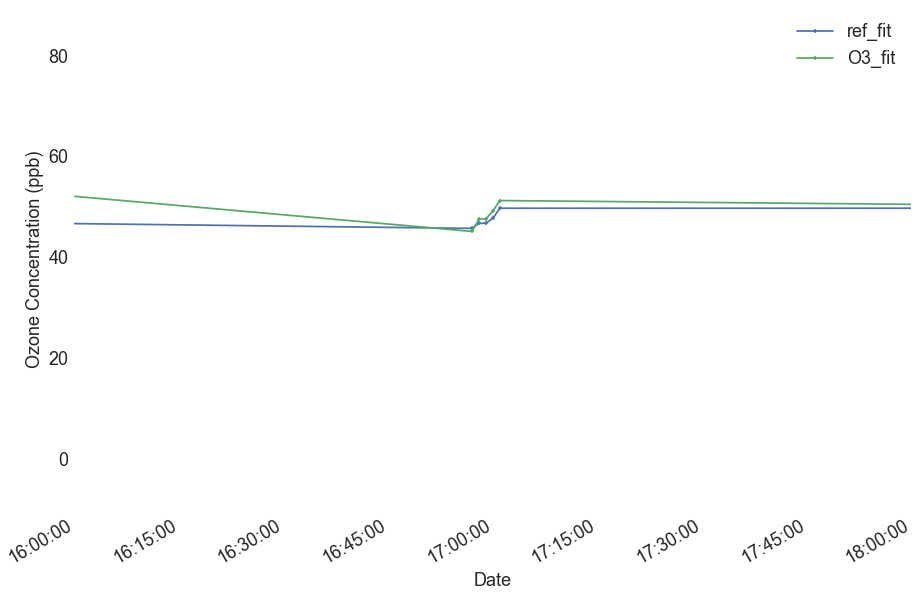

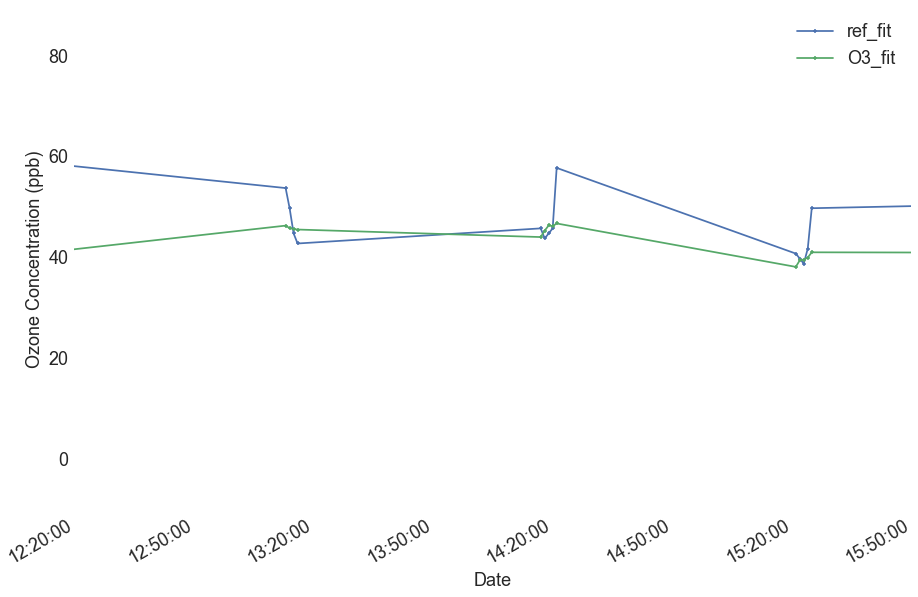

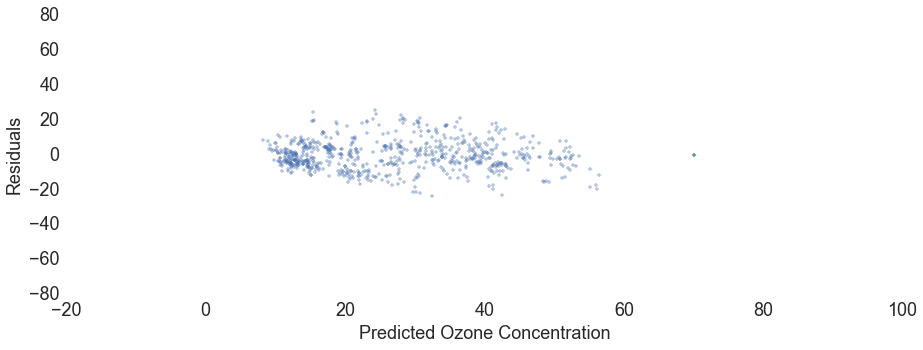

In [384]:
fitted_vs_ref_plot(df_cv_lasso_best, num_good_feat_ridge, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lasso_best, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lasso_best, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lasso_best, pod_number, 3, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lasso_best, pod_number, 4, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lasso_best, pod_number, 5, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lasso_best, pod_number, 6, ref_column)
resid = plot_resid_vs_conc(df_cv_lasso_best, ref_column)

#Support Vector Machine- Best Features

In [385]:
RMSE_CV_day, df_svm_fit, df_H_svm = fit_svm_and_find_MSE(best_features, df_tr, days_tr, ref_column, cutoff_value, df_hold, cust_mse_fact)  

8-2
8-3
8-4
8-6
8-7
8-8
8-9
8-10
8-11
{'epsilon': 0.1, 'C': 1}
Training RMSE: 2.8
Cross-Validation RMSE: 3.0 , High-Value CV RMSE: 4.0 , CV High Diff. in Mean (>50): -11.6
Holdout RMSE: 10.0 , High-Value Holdout RMSE: 22.0 , Holdout High Diff. in Mean.: -19.4


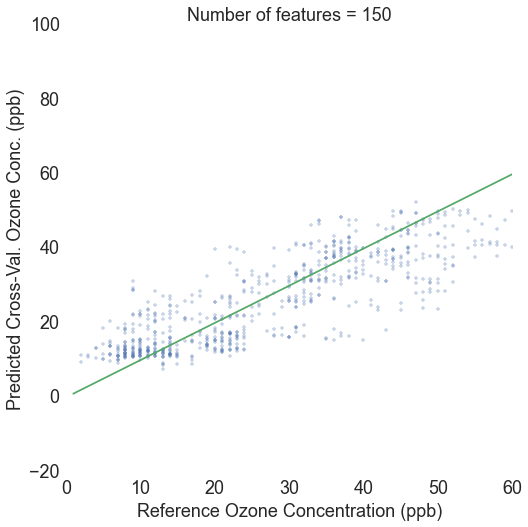

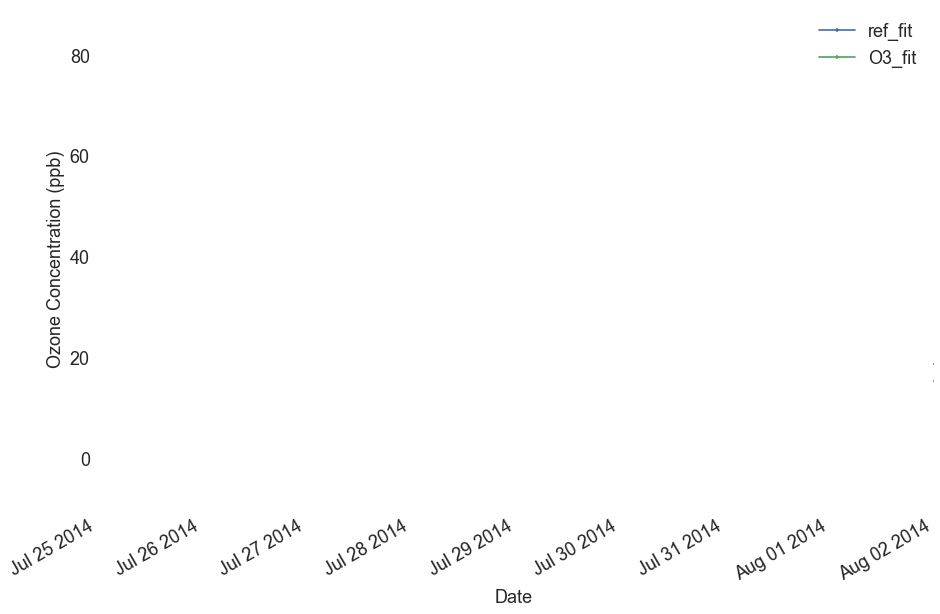

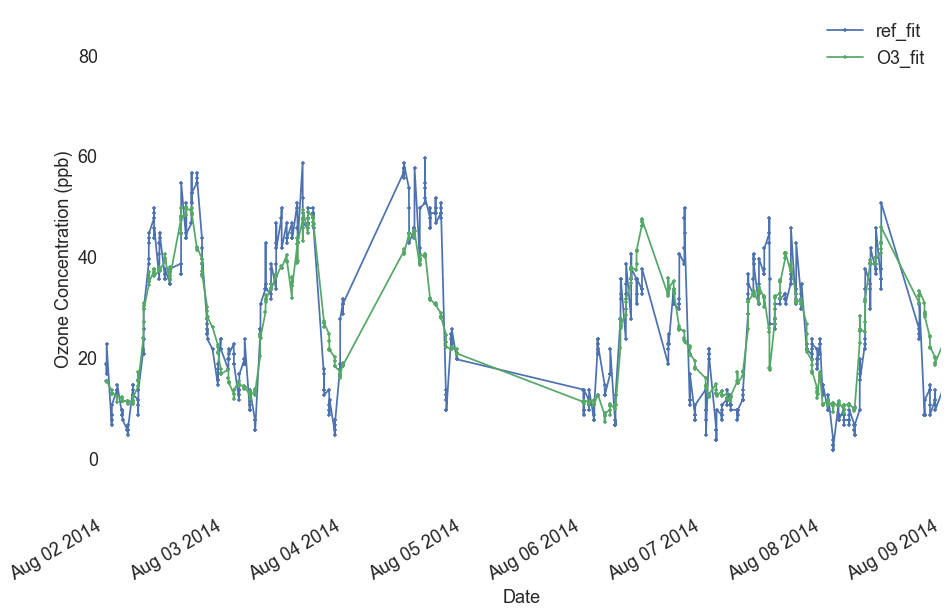

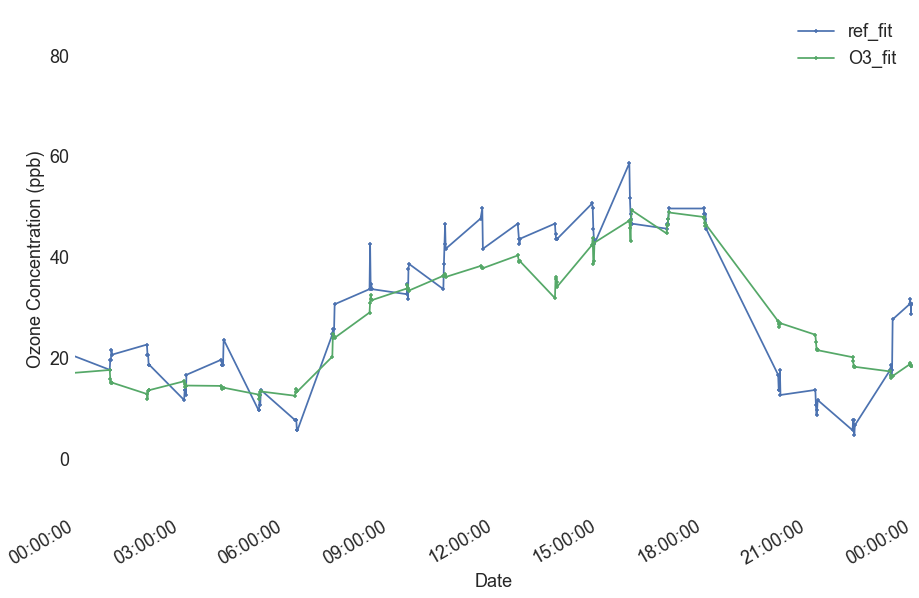

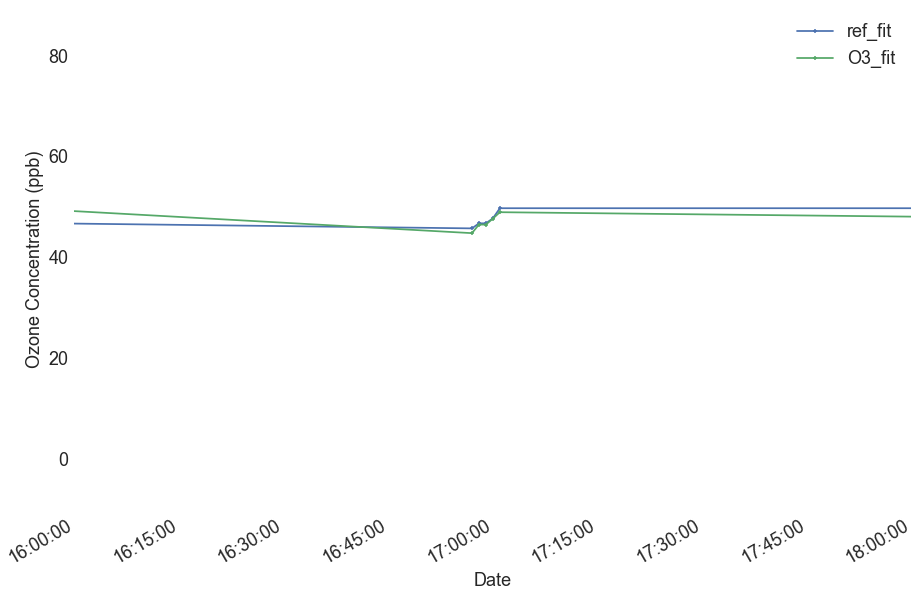

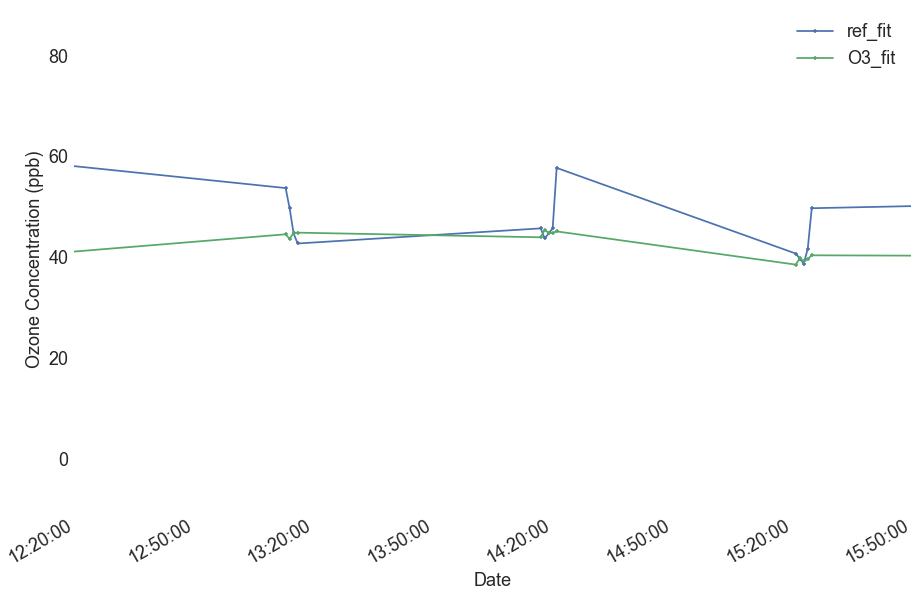

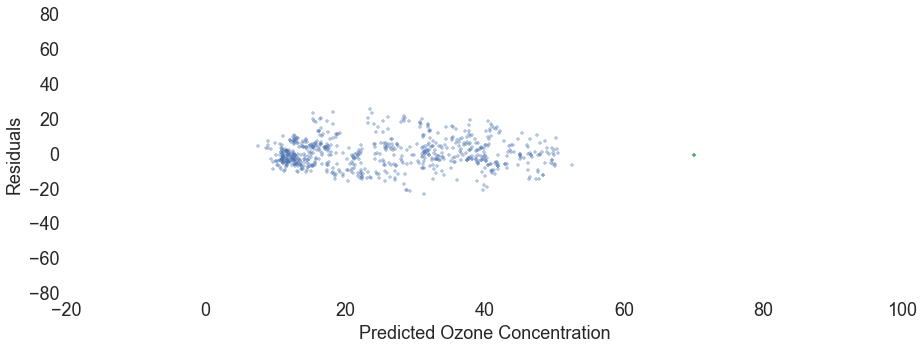

In [386]:
fitted_vs_ref_plot(df_svm_fit, num_good_feat_ridge, ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit, pod_number, 4, ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit, pod_number, 5, ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit, pod_number, 6, ref_column)
resid = plot_resid_vs_conc(df_svm_fit, ref_column)

#Support Vector Machine- All Features

In [387]:
RMSE_CV_day_all, df_svm_fit_all, df_H_svm_all = fit_svm_and_find_MSE(all_features, df_tr, days_tr, ref_column, cutoff_value, df_hold, cust_mse_fact)  

8-2
8-3
8-4
8-6
8-7
8-8
8-9
8-10
8-11
{'epsilon': 0.1, 'C': 1}
Training RMSE: 2.8
Cross-Validation RMSE: 3.0 , High-Value CV RMSE: 4.0 , CV High Diff. in Mean (>50): -11.2
Holdout RMSE: 10.0 , High-Value Holdout RMSE: 21.0 , Holdout High Diff. in Mean.: -18.3


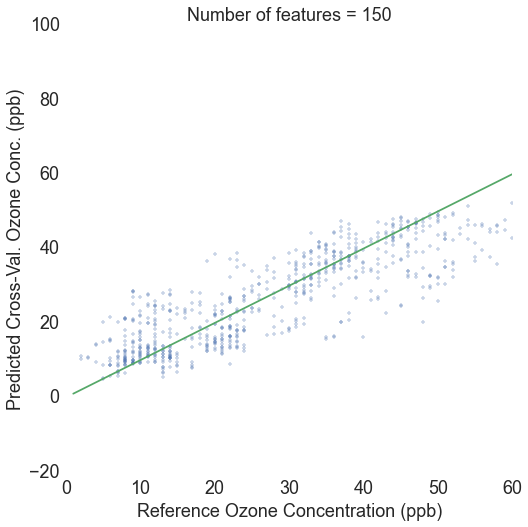

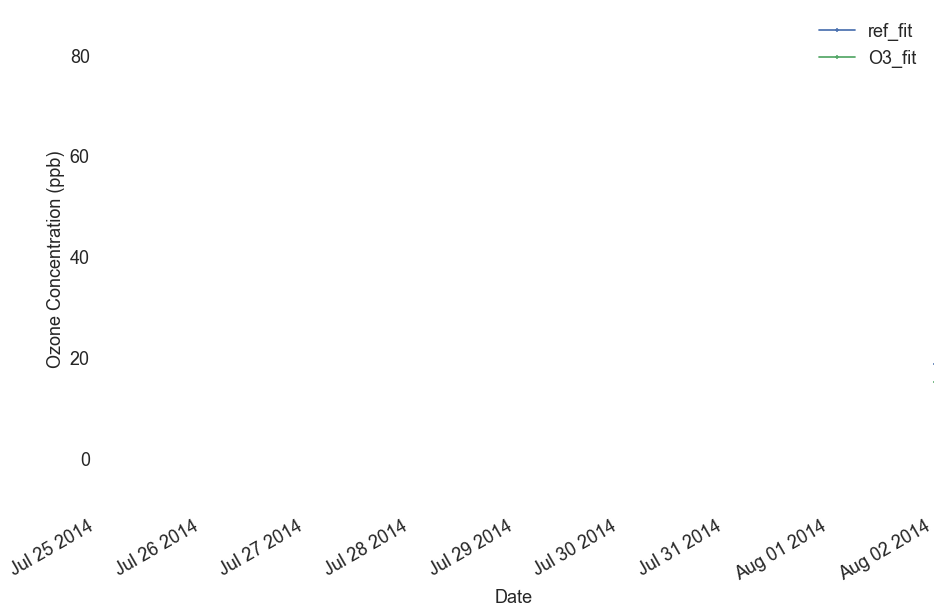

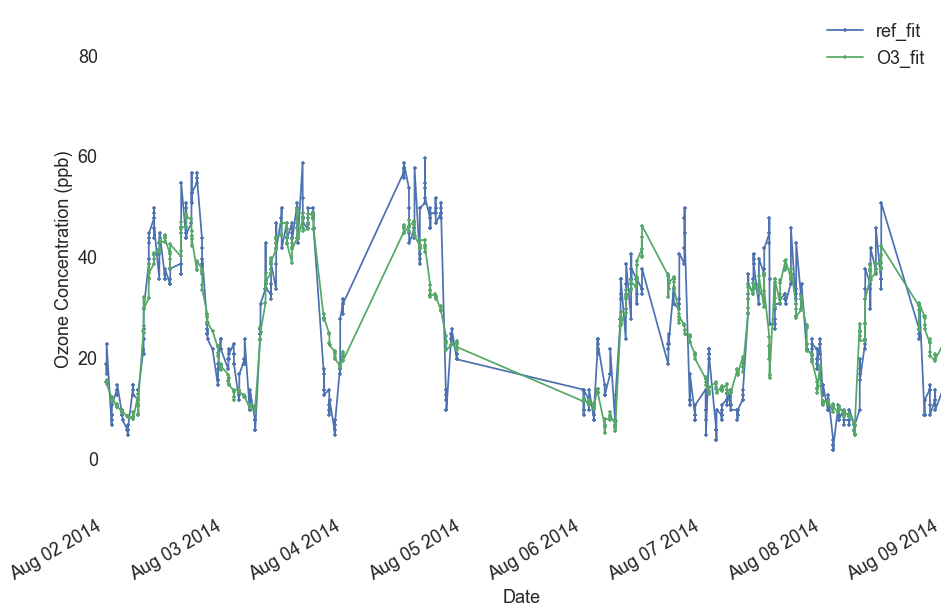

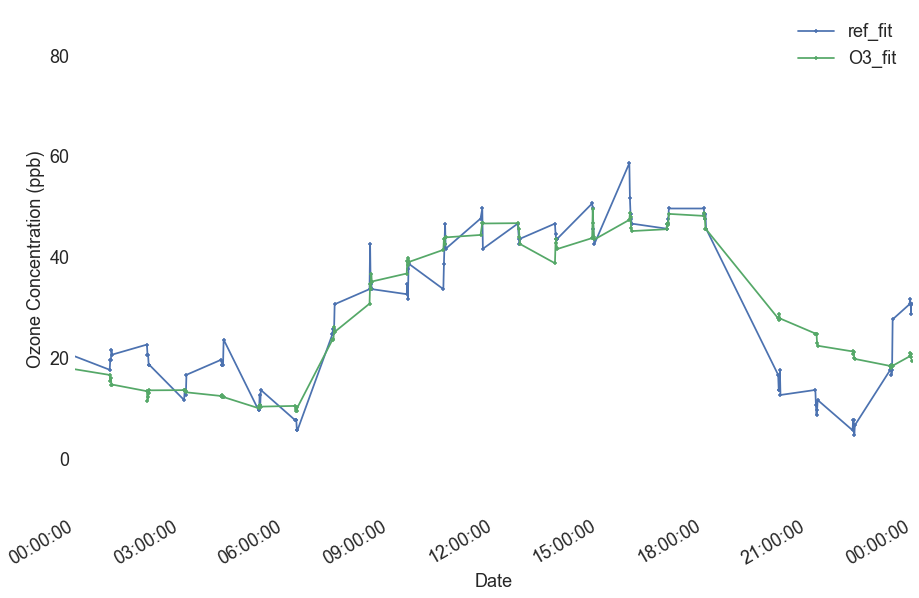

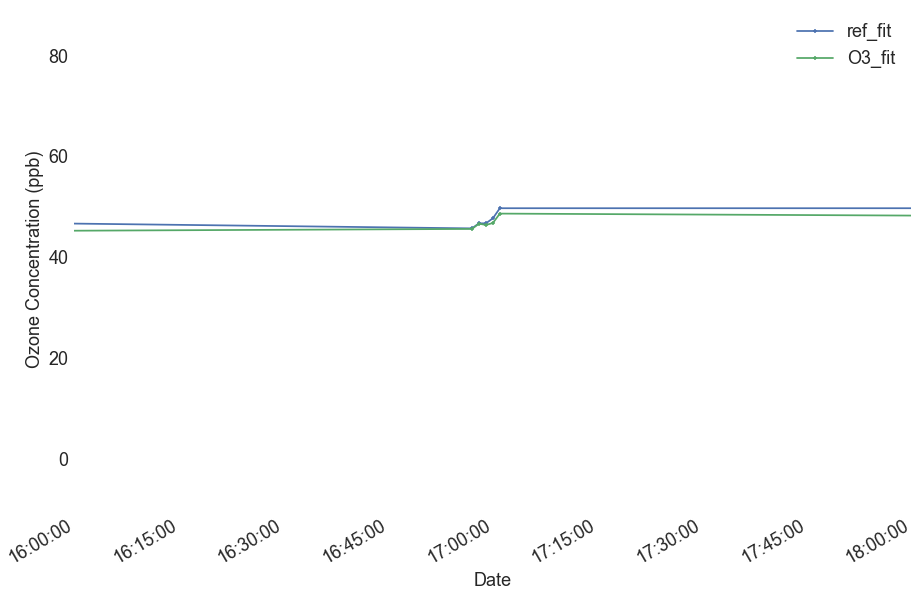

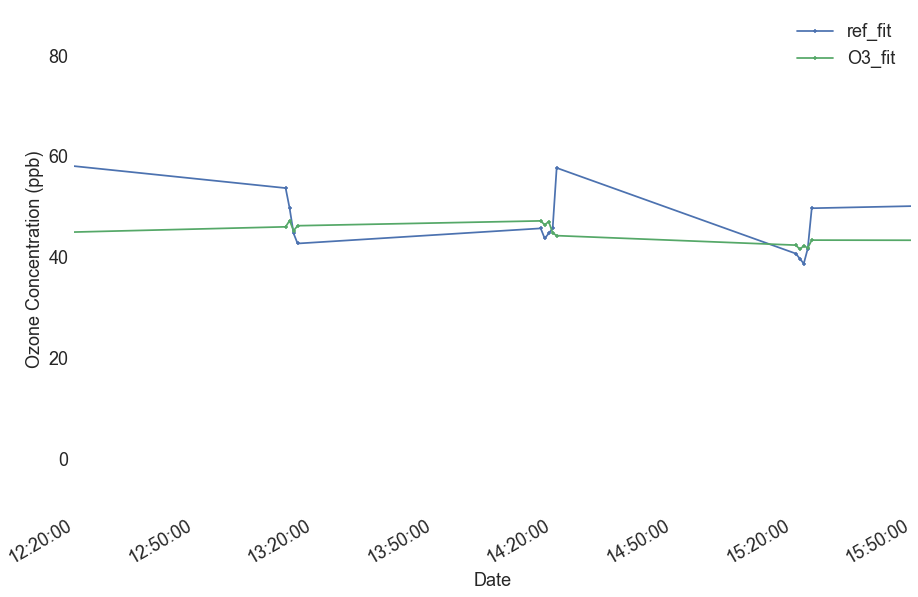

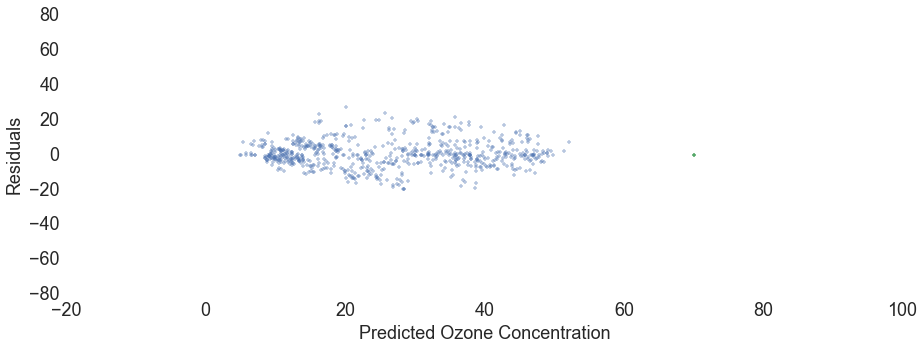

In [388]:
fitted_vs_ref_plot(df_svm_fit_all, len(all_features), ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit_all, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit_all, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit_all, pod_number, 4, ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit_all, pod_number, 5, ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit_all, pod_number, 6, ref_column)
resid = plot_resid_vs_conc(df_svm_fit_all, ref_column)

#Random Forest- All

In [389]:
MSE_CV, df_fit_rf = find_MSE_random_forest(df_fits, fs_features, days_tr, 0, ref_column)

8-2 Cross-Validation RMSE:  7.6
8-3 Cross-Validation RMSE:  9.9
8-4 Cross-Validation RMSE:  13.5
8-6 Cross-Validation RMSE:  10.4
8-7 Cross-Validation RMSE:  8.9
8-8 Cross-Validation RMSE:  8.3
8-9 Cross-Validation RMSE:  8.3
8-10 Cross-Validation RMSE:  9.1
8-11 Cross-Validation RMSE:  8.2


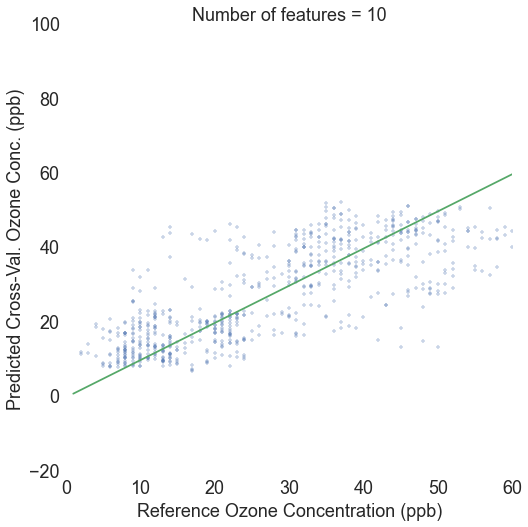

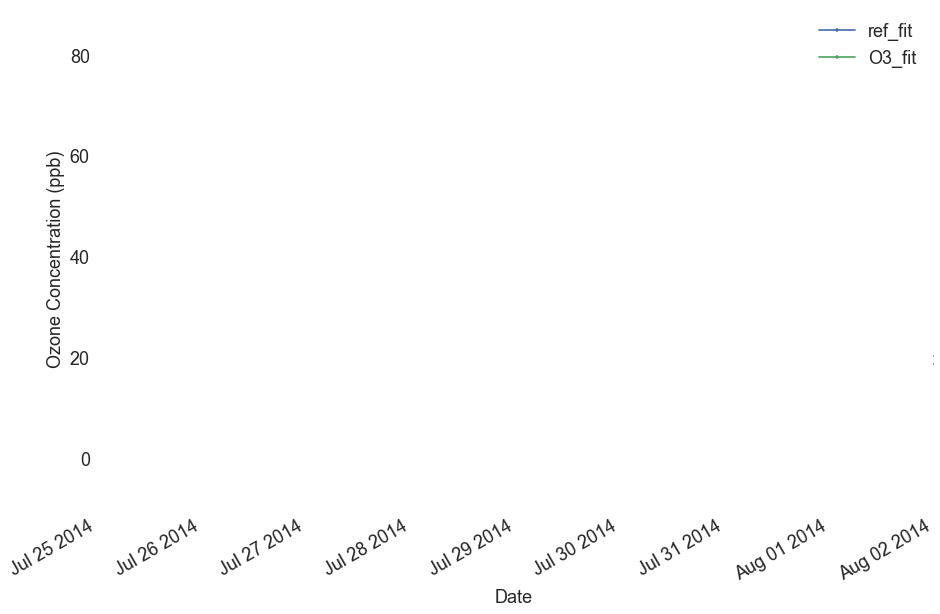

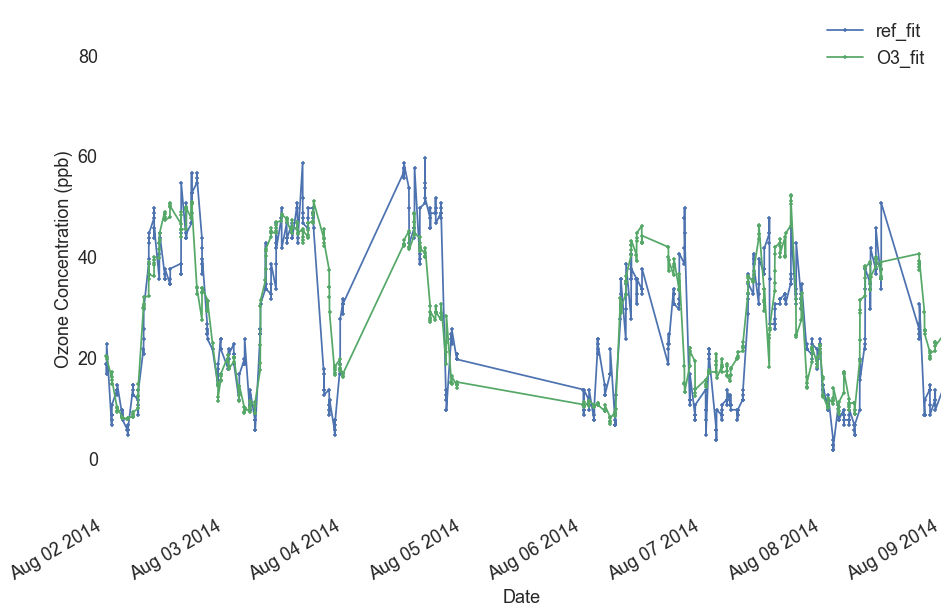

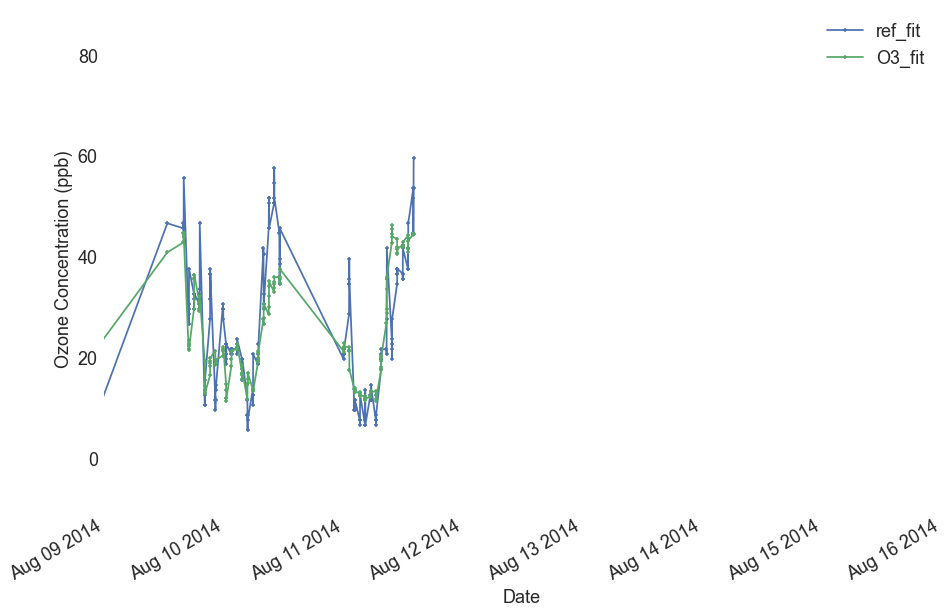

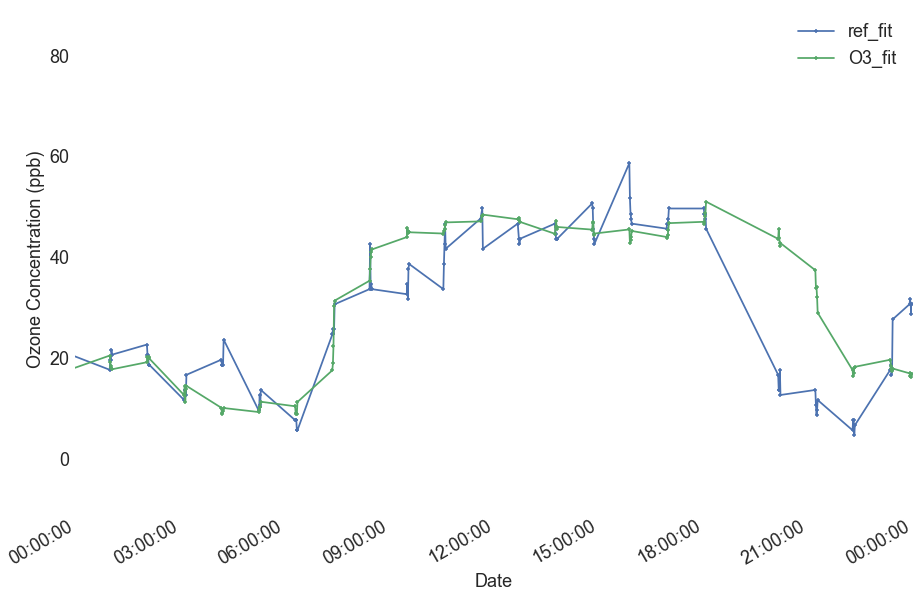

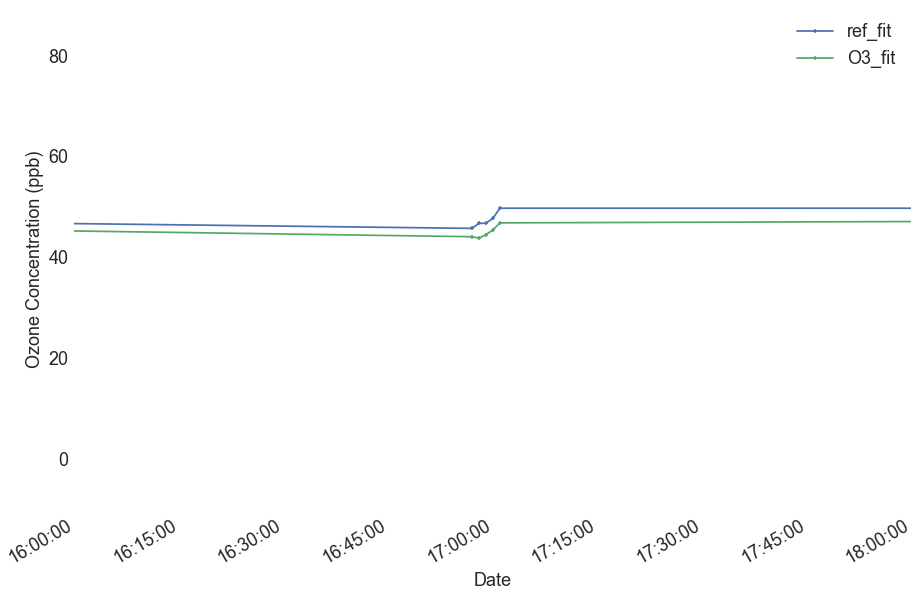

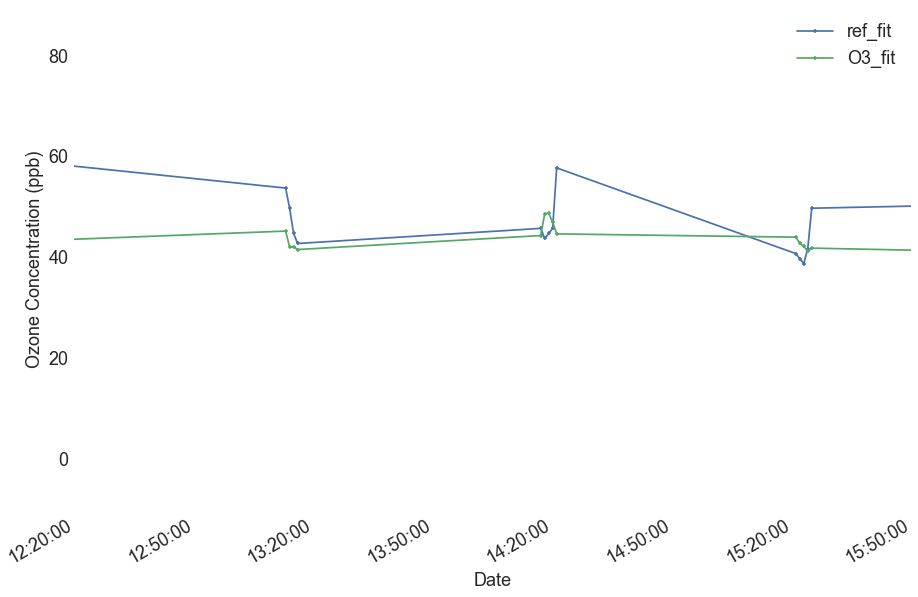

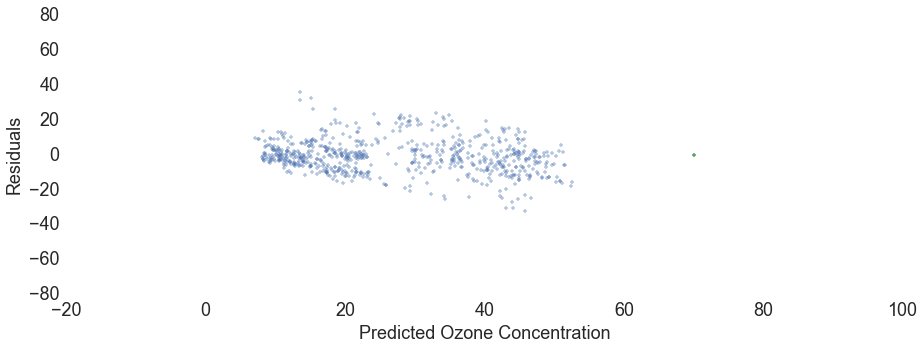

In [390]:
fitted_vs_ref_plot(df_fit_rf, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf, pod_number, 3, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf, pod_number, 4, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf, pod_number, 5, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf, pod_number, 6, ref_column)
resid = plot_resid_vs_conc(df_fit_rf, ref_column)

#Random Forest- Base

In [391]:
MSE_CV_base, df_fit_rf_base = find_MSE_random_forest(df_fits, base_features, days_tr, 0, ref_column)

8-2 Cross-Validation RMSE:  8.8
8-3 Cross-Validation RMSE:  9.5
8-4 Cross-Validation RMSE:  17.3
8-6 Cross-Validation RMSE:  10.7
8-7 Cross-Validation RMSE:  10.3
8-8 Cross-Validation RMSE:  8.9
8-9 Cross-Validation RMSE:  7.9
8-10 Cross-Validation RMSE:  7.8
8-11 Cross-Validation RMSE:  6.9


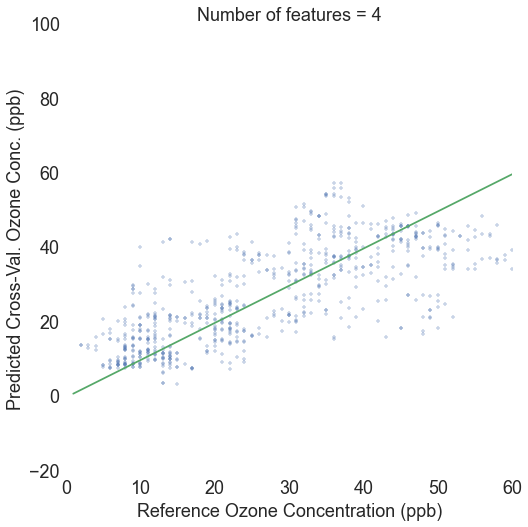

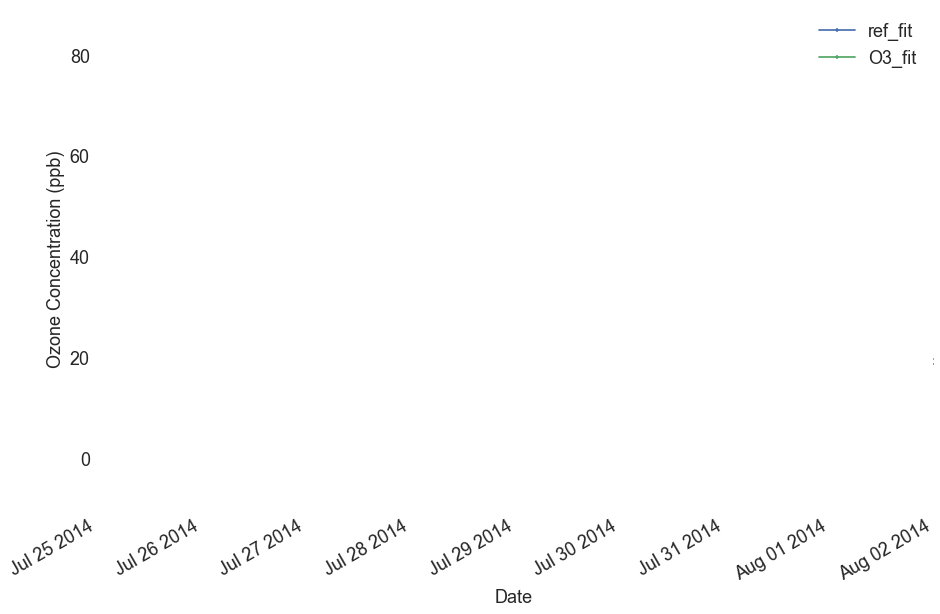

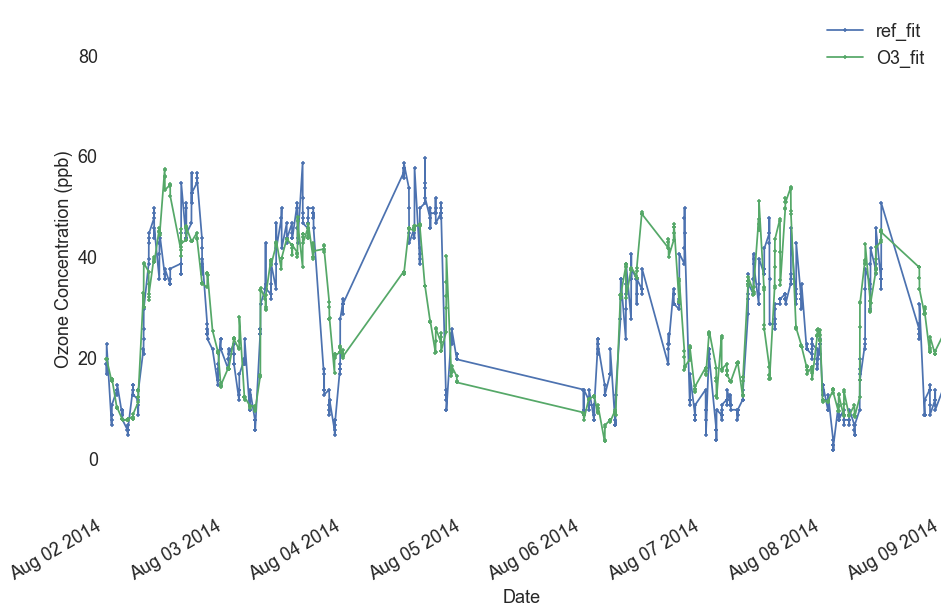

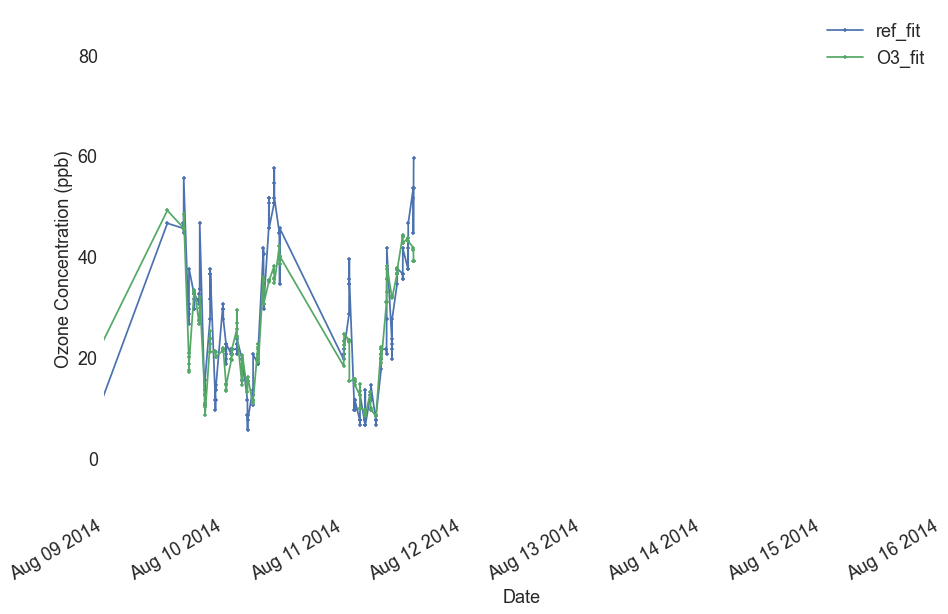

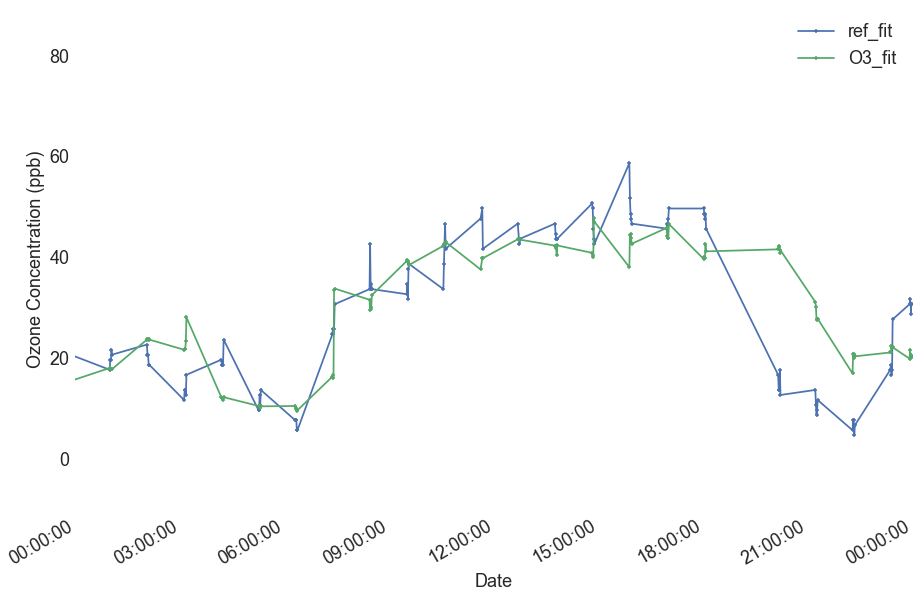

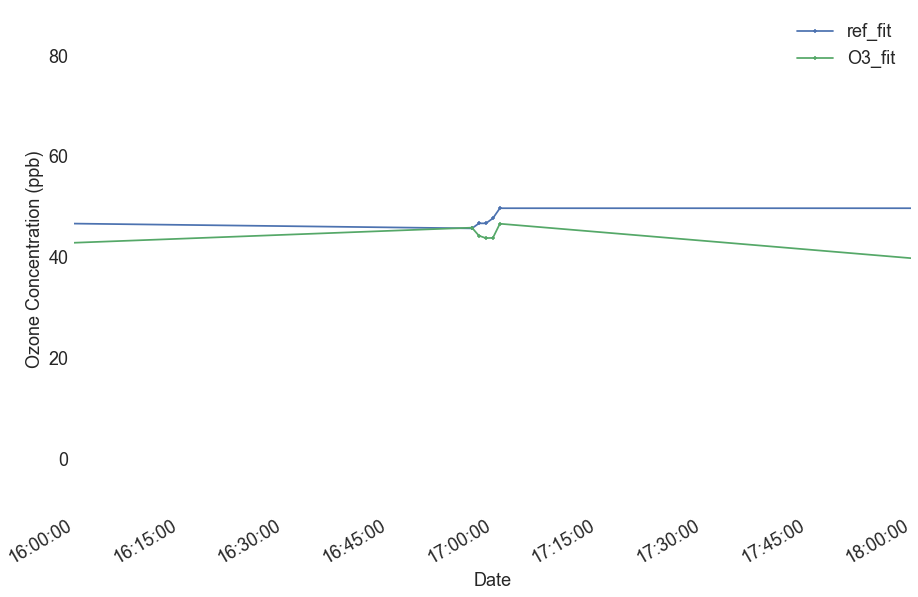

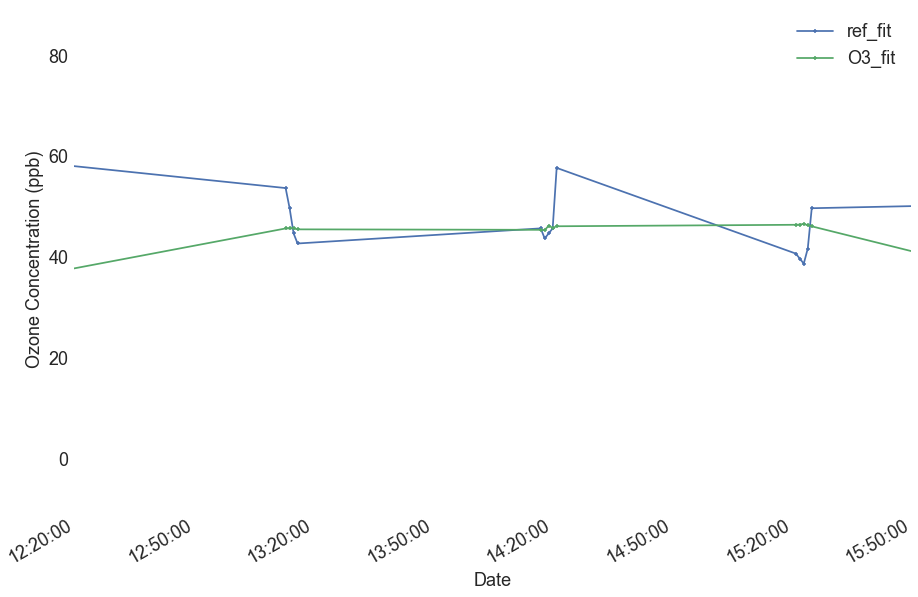

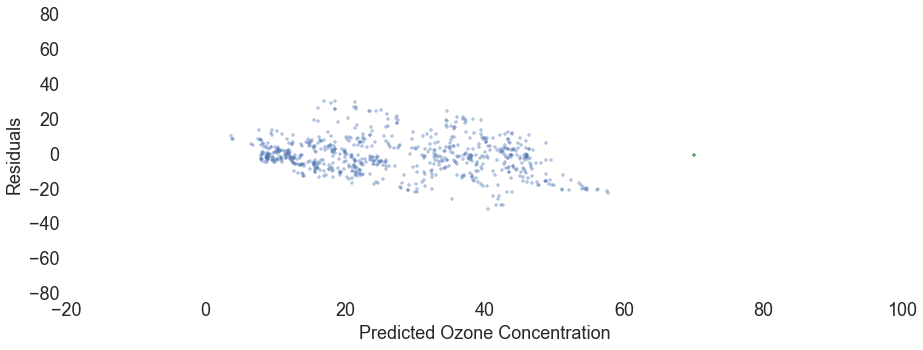

In [392]:
fitted_vs_ref_plot(df_fit_rf_base, 4, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf_base, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf_base, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf_base, pod_number, 3, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf_base, pod_number, 4, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf_base, pod_number, 5, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf_base, pod_number, 6, ref_column)
resid = plot_resid_vs_conc(df_fit_rf_base, ref_column)